# Retail - PGP
### Problem Statement
- It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.
- Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits
- Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).

### Dataset Description
This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

<pre>
Variables	      Description

InvoiceNo	      Invoice number. Nominal, a six digit integral number uniquely assigned to each transaction. 
                   If this code starts with letter 'c', it indicates a cancellation.
StockCode	      Product (item) code. Nominal, a five digit integral number uniquely assigned to each distinct product
Description	    Product (item) name. Nominal.
Quantity	       The quantities of each product (item) per transaction. Numeric.
InvoiceDate	    Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice	      Unit price. Numeric, product price per unit in sterling.
CustomerID	     Customer number. Nominal, a six digit integral number uniquely assigned to each customer.
Country	        Country name. Nominal, the name of the country where each customer resides.
</pre>

In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson, kurtosis
import warnings
warnings.filterwarnings ('ignore')
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [207]:
# importing the data

path = 'H:/Documents/Study material/Data Science course/Capstone Project/Project 3 - Retail - PGP/Online Retail.xlsx'
retail = pd.read_excel (path)
retail.head ()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Step 1: Initial EDA and data cleaning
- We will explore the columns (no. of records, columns, distributions, missing values, junk values, data type)
- perform statistical summary of the data.
- impute the missing values outliers and out of range values.

In [208]:
# checking the information of the data set

retail.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


##### Inferences :
    1. There are 8 columns and 541909 records in the data.
    2. There missing values in 2 columns - CustomerID, Description.
    3. Invoice date is the date column, Quantity and Unit Price are other important columns.

In [209]:
# checking the percentage of missing values in the data

((retail.isna ().sum () [retail.isna ().any ()] * 100) / retail.shape [0]).apply (lambda x : str (round (x, 2)) + ' %')

Description     0.27 %
CustomerID     24.93 %
dtype: object

##### Inferences :
    1. The description column gives name of the products. Ideally each Stock Code should have a unique 
       product description. Though description should not be an important column for the analysis but still 
       we can use this relationship for imputation (if required).
    2. The customer ID column is used for identifying all the unique customers in the data set. This is 
       an important column because clustering will be performed on this data. Each invoice number should '
       have a unique customer ID associated with it. We can use this relationship for imputation (if required)
       and if possible.
       
Let's check for duplicated data records.

In [210]:
# Checking total count of duplicated data records
print ('The number of duplicated data records =', retail.duplicated ().sum ())

# printing the first 15 duplicated records
retail [retail.duplicated (keep = False)].head (15)

The number of duplicated data records = 5268


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
548,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


##### We can drop these duplicated records

In [211]:
# removing the duplicated records

print ('The shape of the data set before removing duplicates =', retail.shape)
retail.drop_duplicates (inplace = True)
print ('The shape of the data set after removing duplicates =', retail.shape)

The shape of the data set before removing duplicates = (541909, 8)
The shape of the data set after removing duplicates = (536641, 8)


In [212]:
# Let's check statistical summary of all the columns

retail.sort_values ('InvoiceDate').describe (include = 'all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,536641.0,536641,535187,536641.000000,536641,536641.000000,401604.000000,536641
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2301,2357,NaN,1114,NaN,NaN,490300
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.620029,NaN,4.632656,15281.160818,NaN
std,NaN,NaN,NaN,219.130156,NaN,97.233118,1714.006089,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13939.000000,NaN


##### Inferences :
    1. The transactions mentioned in the data set are from 01 Dec 2010 to 09 Dec 2011.
    2. The negative values in Quantity and Unit price are probably cancelled transactions and must be analyzed 
       and removed.
    3. The max and min value in Quantity have the same value with the opposite signs. This raises the possibility that
       some of the transactions were registered and then cancelled later. We must analyze this possibility.
    4. The max values in Quantity and Unit price are way beyond the third quartile which must be analyzed.
    5. The data has customers from 38 unique countries.
    6. The column description says that the Invoice no is a 6 digit integral number and Stock code is a 5 digit 
       integral number.

In [213]:
# Let's sort the data frame using Invoice date to analyze the cancelled transactions

retail = retail.sort_values ('InvoiceDate').reset_index (drop = True)

In [214]:
# Let's check the data where Unit price < 0

retail [retail.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
297646,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
297647,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


##### There has been a debt adjustment of $22124 during the given period. 
We can drop these rows later as we don't require this for further analysis.

In [215]:
# the column description for Invoice no says that all cancelled transactions starts with 'C'
# Let's check the statistical summary for all such cancelled transactions

retail [retail.InvoiceNo.str.startswith ('C', na = False)].describe ().T

,count,mean,std,min,25%,50%,75%,max
Quantity,9251.0,-29.787050,1147.997592,-80995.00,-6.00,-2.00,-1.00,-1.0
UnitPrice,9251.0,48.570430,667.926393,0.01,1.45,2.95,5.95,38970.0
CustomerID,8872.0,14990.152953,1708.230387,12346.00,13505.00,14868.00,16393.00,18282.0


##### Inferences :
    1. There are in total 9251 rows where the Invoice no starts with 'C'.
    2. All values in these rows have negative quantity.
    3. There are some rows where CustomerId is not present. We can directly drop them.
    4. All the rows here have valid Unit price. Hence, we can analyze these rows further.
    
Let's check other rows where Quantity is less than 0.

In [216]:
# Let's check the rows where Invoice no. does not start with C but Quantity is less than 0

retail [(retail.InvoiceNo.str.startswith ('C', na = False) == False) & (retail.Quantity < 0)].describe ().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1336.0,-154.907934,588.292456,-9600.0,-84.0,-30.0,-8.0,-1.0
UnitPrice,1336.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CustomerID,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### These rows neither contains a valid unit price nor it contains a valid customer ID. We can drop these rows later.
Let's analyze and remove the cancelled transactions.

In [217]:
# creating a subset of all cancelled transactions with valid customer ID

cancelled = retail [retail.InvoiceNo.str.startswith ('C', na = False) & (retail.CustomerID.notna ())]
print ('The shape of the cancelled subset data =', cancelled.shape)
cancelled.head ()

The shape of the cancelled subset data = (8872, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
119,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
237,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


##### Inferences :
    1. There are some integer type of stock code, some alphabetic and some alphanumeric.
    2. We can use the stock code, quantity and customer ID to identify the corresponding cancelled transactions
       with positive quantity.

In [218]:
# Let's combine the Stock code, absolute value of Quantity and customer ID columns in the cancelled data
# We will also extract this new column into a list

cancelled ['check'] = cancelled.StockCode.astype(str) + '-' + cancelled.Quantity.abs().astype(str) + '-' + cancelled.CustomerID.astype (str)
cancelled_check = cancelled.check.to_list ()

In [219]:
# finding all the row where the quantity > 0 but later cancelled

# creating a combined column same as above but with using actual value of Quantity instead of absolute
retail ['check'] = retail.StockCode.astype(str) + '-' + retail.Quantity.astype(str) + '-' + retail.CustomerID.astype (str)

# defining a function to find the cancelled row
def find_cancelled (x) :
    if x in cancelled_check :
        del (cancelled_check [cancelled_check.index (x)])
        return (True)
    else :
        return (False)

retail ['cancelled'] = retail.check.apply (find_cancelled)

print ('Number of cancelled rows found =', retail.cancelled.sum ())

Number of cancelled rows found = 3167


##### now we can remove the following -
1. all negative quantity
2. all corresponding cancelled transactions
3. all negative unit price
4. all invoice no which are not 6 digit integral number
5. all stockcode which are not 5 digit integral number

In [220]:
# Let's define the condition for each

cond1 = (retail.Quantity > 0)
cond2 = (retail.cancelled == False)
cond3 = (retail.UnitPrice > 0)

# defining a function to check the length of the invoice no and stock code
def check_len (x) :
    
    if (len (str (x ['InvoiceNo'])) == 6) & (len (str (x ['StockCode'])) == 5) :
        return (True)
    
    else :
        return (False)
    
# defining the condition for the same
cond4 = retail [['InvoiceNo', 'StockCode']].apply (check_len, axis = 1)

##### Now that we have defined all the conditions, lets apply it on the data set

In [221]:
# applying all the conditions on the data
retail = retail [cond1 & cond2 & cond3 & cond4]

# removing the extra created columns
retail.drop (columns = ['check', 'cancelled'], inplace = True)

# printing the shape of the remaining data set
print ('The shape of the remaining data =', retail.shape)

The shape of the remaining data = (469409, 8)


In [222]:
# Let's check the statistical summary of the data again

retail.describe (include = 'all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,469409.0,469409.0,469409,469409.000000,469409,469409.000000,355433.000000,469409
unique,19416.0,2865.0,3063,NaN,18018,NaN,NaN,38
top,573585.0,22423.0,REGENCY CAKESTAND 3 TIER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,988.0,1954.0,1954,NaN,988,NaN,NaN,429131
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,10.434500,NaN,3.268127,15291.186046,NaN
std,NaN,NaN,NaN,37.992856,NaN,4.330920,1712.295804,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.040000,12347.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13959.000000,NaN


##### Now that we have kept only postive values, let's check the distribution of the 2 columns.

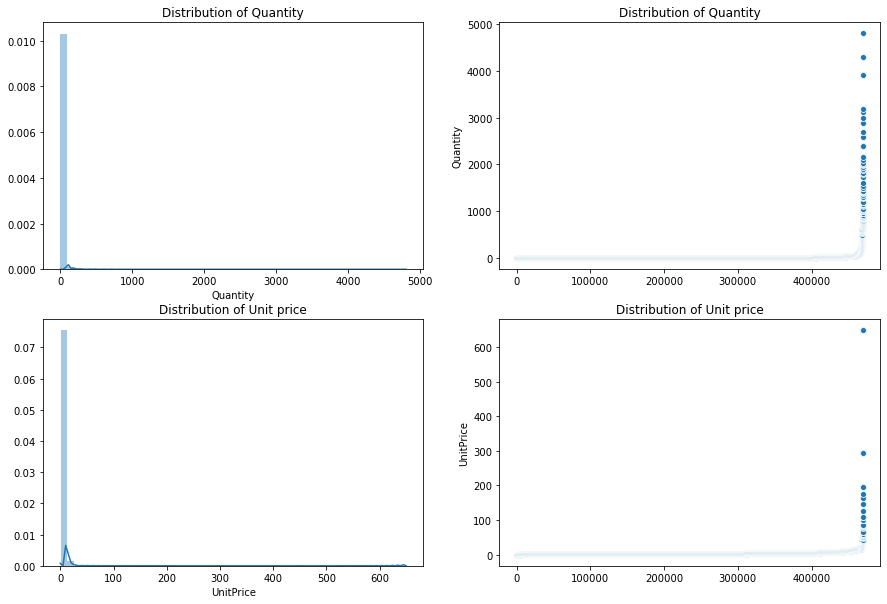

In [223]:
# plotting the distribution and scatter plot

plt.figure (figsize = (15,10))

plt.subplot (221)
sns.distplot (retail.Quantity)
plt.title ('Distribution of Quantity')

plt.subplot (222)
sns.scatterplot (range (retail.shape [0]), retail.Quantity.sort_values ())
plt.title ('Distribution of Quantity')

plt.subplot (223)
sns.distplot (retail.UnitPrice)
plt.title ('Distribution of Unit price')

plt.subplot (224)
sns.scatterplot (range (retail.shape [0]), retail.UnitPrice.sort_values ())
plt.title ('Distribution of Unit price');

##### Inferences : 
    1. There are some obvious outliers in the Quantity column (>3500)
    2. There are some obvious outliers in the Unit price column too (>250)
    
Let's check these rows and see if they are relevant or not.

In [225]:
display (retail [retail.Quantity > 3500])
display (retail [retail.UnitPrice > 250])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
96514,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
204412,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
418128,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4910,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom
117702,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452.0,United Kingdom
132768,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.0,13452.0,United Kingdom
169683,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973.0,United Kingdom
204066,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015.0,United Kingdom
220817,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom
220827,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom


##### Inferences :
    1. The values from quantity column seems to be valid.
    2. But looking at the last 2 rows in the Unit price, there seems to be incorrect entry of quantity.
        - The quantity for row number 220817 should be 1 instead of 60.
    3. Usually there should not be a huge difference between the unit price of a product, so we can analyze
       the standard deviation in the unit price of each product.
But we will first treat the missing values in the data.

In [226]:
# Correcting the quantity of the row number 220817

retail.loc [220817, 'Quantity'] = 1

In [227]:
# checking for remaining missing values in the data

retail.isna ().sum () [retail.isna ().any ()]

CustomerID    113976
dtype: int64

##### There are still 113976 missing values in customer ID

In [228]:
# checking the rows with missing values of Customer ID

retail [retail.CustomerID.isna ()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1410,536544,90022,EDWARDIAN DROP EARRINGS JET BLACK,1,2010-12-01 14:32:00,3.81,NaN,United Kingdom
1411,536544,90071,RUBY GLASS CLUSTER EARRINGS,1,2010-12-01 14:32:00,1.26,NaN,United Kingdom
1414,536544,90116,FRUIT SALAD BAG CHARM,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1419,536544,90099,NECKLACE+BRACELET SET BLUE HIBISCUS,1,2010-12-01 14:32:00,5.06,NaN,United Kingdom
1421,536544,85176,SEWING SUSAN 21 NEEDLE SET,5,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536275,581498,22187,GREEN CHRISTMAS TREE CARD HOLDER,6,2011-12-09 10:26:00,8.29,NaN,United Kingdom
536276,581498,22193,RED DINER WALL CLOCK,1,2011-12-09 10:26:00,16.63,NaN,United Kingdom
536277,581498,22195,LARGE HEART MEASURING SPOONS,3,2011-12-09 10:26:00,3.29,NaN,United Kingdom
536278,581498,22196,SMALL HEART MEASURING SPOONS,2,2011-12-09 10:26:00,1.63,NaN,United Kingdom


##### We cannot find any useful insights from these records. But we know that each Invoice no can have only 1 customer ID. This is the only possible way to impute the missing values in customer ID. Let's analyze the invoice column against missing customer ID.

In [229]:
# Finding unique Invoice numbers where customer ID is missing
invno_miss = retail.InvoiceNo [retail.CustomerID.isna ()].unique ()

# Finding unique Invoice numbers where customer ID is present
invno_not_miss = retail.InvoiceNo [retail.CustomerID.notna ()].unique ()

# Finding any invoice number with both missing and available customer ID
check = [val for val in invno_miss if val in invno_not_miss]

print ('We can impute customer ID with {} invoice numbers'.format (len (check)))

We can impute customer ID with 0 invoice numbers


##### Unfortunately there is no way impute the remaining missing customer IDs. Hence, we need to drop them.

In [230]:
retail.dropna (inplace = True)
print ('The shape of the remaining data =', retail.shape)

The shape of the remaining data = (355433, 8)


In [242]:
# Let's analyze the standard deviation of unit price of each product

# aggregating the data product wise
prod_analysis = retail.groupby ('StockCode').agg ({'UnitPrice' : ['std', 'min', 'max']})
prod_analysis.columns = ['Unitprice_std', 'Unitprice_min', 'Unitprice_max']

# checking the products where standard deviation > 5
check_prod = prod_analysis [prod_analysis.Unitprice_std > 5].sort_values ('Unitprice_std', 
                                                                          ascending = False)
check

,Unitprice_std,Unitprice_min,Unitprice_max
StockCode,,,
10002,0.000000,0.85,0.85
10080,0.100380,0.39,0.85
10120,0.000000,0.21,0.21
10125,0.158395,0.42,0.85
10133,0.188490,0.42,0.85
...,...,...,...
90191,5.238320,2.95,12.75
90192,0.000000,4.95,4.95
90194,0.000000,4.25,4.25


##### Let's analyze them one by one.

In [255]:
# creating a loop to analyze each product

for StockCode in check_prod.index :
    clear_output ()    # to clear the output for next product to display
    data = retail [retail.StockCode == StockCode]
    print (data.UnitPrice.value_counts ())
    display (data)
    if input ('press n to cancel or press any other key to continue ') == 'n' :
        break

12.75    4
2.95     3
Name: UnitPrice, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
94834,544463,90191,SILVER LARIAT 40CM,1,2011-02-20 14:31:00,12.75,12988.0,United Kingdom
259187,559822,90191,SILVER LARIAT 40CM,1,2011-07-12 17:15:00,12.75,16365.0,United Kingdom
323057,565445,90191,SILVER LARIAT 40CM,1,2011-09-04 14:50:00,12.75,13548.0,United Kingdom
368248,569211,90191,SILVER LARIAT 40CM,2,2011-10-02 12:04:00,12.75,15774.0,United Kingdom
400564,571653,90191,SILVER LARIAT 40CM,6,2011-10-18 12:17:00,2.95,14298.0,United Kingdom
404477,571909,90191,SILVER LARIAT 40CM,5,2011-10-19 15:08:00,2.95,15006.0,United Kingdom
432800,574149,90191,SILVER LARIAT 40CM,6,2011-11-03 11:29:00,2.95,13709.0,United Kingdom


press n to cancel or press any other key to continue 


##### The change in the unit price of products are due to the following reasons :
    1. Seasonal change
    2. Discounts in particular season
    3. Bulk order pricing
No cleaning is required for this.

##### Now, that we have cleaned all the data, we can do some further EDA.

### Step 2: Data Exploration
- perform statistical summary of the data.
- generate some required features from the existing ones.
- create monthly cohorts, analyze the cohorts and draw some useful insights.

In [256]:
# Let's check the statistical summary of the data

retail.describe (include = 'all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,355433.0,355433.0,355433,355433.000000,355433,355433.000000,355433.000000,355433
unique,18087.0,2778.0,2975,NaN,16884,NaN,NaN,37
top,579196.0,22423.0,REGENCY CAKESTAND 3 TIER,NaN,2011-11-28 15:54:00,NaN,NaN,United Kingdom
freq,485.0,1660.0,1660,NaN,485,NaN,NaN,316461
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.718436,NaN,2.871112,15291.186046,NaN
std,NaN,NaN,NaN,42.887087,NaN,4.204730,1712.295804,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.040000,12347.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13959.000000,NaN


##### Inferences :
    1. Ideally each product must have a unique stock code but here the count of description and stock code differs.
       We need to explore the reason for it.
    2. As we have seen earlier the max quantity and the max unit price seems to be way beyond the 3rd quartile.
       The 2 variables are highly skewed to the right.
    3. We will have to apply some aggregation for further EDA .
    4. The unit price * quantity will give the price which can be an important feature for RFM analysis.
    5. The last invoice data per customer ID will give the recency feature.
    6. The count of invoice no per customer gives the frequency value.

In [259]:
# checking the Stock code vs product description

check = retail.groupby ('StockCode').agg ({'Description' : 'unique'})
check ['desc_count'] = check.Description.apply (len)
check [check.desc_count > 1].sort_values ('desc_count', ascending = False).sample (15)

,Description,desc_count
StockCode,,
22776,"[SWEETHEART CAKESTAND 3 TIER, CAKESTAND, 3 TIE...",3
23251,"[VINTAGE RED ENAMEL TRIM MUG , ENAMEL MUG PANTRY]",2
22953,"[BIRTHDAY PARTY CORDON BARRIER TAPE, BIRTHDAY ...",2
21175,"[GIN + TONIC DIET METAL SIGN, GIN AND TONIC DI...",2
23240,"[SET OF 4 KNICK KNACK TINS DOILEY , SET OF 4 K...",3
23396,"[BUTTERFLY CUSHION COVER, LA JARDIN BOTANIQUE ...",3
23188,"[VINTAGE 2 METER FOLDING RULER, VINTAGE 2 ME...",2
23522,"[DOG AND BALL WALL ART, WALL ART DOG AND BALL ]",2
23044,"[PAPER LANTERN 9 POINT HOLLY STAR S, PAPER LAN...",2


##### There must have been slight change in the product description but seems to refer to the same product.

In [260]:
# let's create a price column using quantity * unit price

retail ['price'] = retail.Quantity * retail.UnitPrice
retail.head ()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536368,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85


##### We have created the price column. Let's analyze the monthly cohort.

In [261]:
# let's first create a month and year column from the Invoice Date

retail ['invoice_month'] = retail.InvoiceDate.apply (lambda x : x.month)
retail ['invoice_year'] = retail.InvoiceDate.apply (lambda x : x.year)

# since the data is from 01 Dec 2010 to 09 Dec 2011. We can drop the transactions for the month of Dec 2011
# because we have incomplete data for Dec 2011.

retail2 = retail [(retail.invoice_month != 12) | ((retail.invoice_month == 12) & (retail.invoice_year == 2010))]

In [262]:
# Grouping the data by month and aggregating the columns as -
# unique count of invoice no. to get no. of transactions in each month
# unique customer ID to get a list of active customer ID in each month (for calculation retention rate later)
# unique count of customer ID to get no. of active customers in each month

# sum of price to get the revenue generated in each month

month_analysis = retail2.groupby ('invoice_month').agg ({'InvoiceNo' : 'nunique',
                                                         'CustomerID' : ['unique', 'nunique'],
                                                         'price' : 'sum'})

month_analysis.columns = ['invoice_count', 'customers', 'customer_count', 'revenue']

month_analysis

,invoice_count,customers,customer_count,revenue
invoice_month,,,,
1,952,"[13313.0, 18097.0, 16656.0, 16875.0, 13094.0, ...",727,394131.02
2,978,"[15240.0, 14911.0, 14496.0, 17147.0, 17675.0, ...",749,391731.28
3,1293,"[14620.0, 14740.0, 13880.0, 17068.0, 12971.0, ...",963,515513.39
4,1110,"[18161.0, 14886.0, 17613.0, 13694.0, 12523.0, ...",842,399778.17
5,1512,"[15606.0, 14800.0, 16931.0, 15708.0, 14304.0, ...",1046,591870.37
6,1365,"[15643.0, 14842.0, 15124.0, 14646.0, 12423.0, ...",984,555108.41
7,1302,"[16317.0, 13492.0, 14911.0, 17865.0, 17667.0, ...",941,520732.96
8,1248,"[17941.0, 14947.0, 12921.0, 14060.0, 14239.0, ...",926,575010.18
9,1715,"[13509.0, 13305.0, 16187.0, 17306.0, 13631.0, ...",1249,866722.77


In [263]:
# Calculating the retention rate for each month
# retention rate = A / E
# A = no. of active customers in the current month which have shopped in the previous month
# E = no. of existing customer (who have shopped in the previous month)
# since, we have data from Dec 2010 to Dec 2011, we cannot calculate the retention rate for Dec 2010

month_analysis ['retention_rate'] = 0    # creating the retention column
for i in range (11) :    # since, we will calculate retention rate for month 1-11 (Jan to Nov)
    prev_month_cust = month_analysis.iloc [i-1, 1]    # list of previous month customers
    curr_month_cust = month_analysis.iloc [i, 1]      # list of current month customers
    act_cust = [cust for cust in prev_month_cust if cust in curr_month_cust]    # list of active customers
    retention_rate = len (act_cust) / len (prev_month_cust)
    month_analysis.iloc [i, 4] = retention_rate    # updating the retention rate for the month
    
month_analysis

,invoice_count,customers,customer_count,revenue,retention_rate
invoice_month,,,,,
1,952,"[13313.0, 18097.0, 16656.0, 16875.0, 13094.0, ...",727,394131.02,0.361556
2,978,"[15240.0, 14911.0, 14496.0, 17147.0, 17675.0, ...",749,391731.28,0.350757
3,1293,"[14620.0, 14740.0, 13880.0, 17068.0, 12971.0, ...",963,515513.39,0.383178
4,1110,"[18161.0, 14886.0, 17613.0, 13694.0, 12523.0, ...",842,399778.17,0.307373
5,1512,"[15606.0, 14800.0, 16931.0, 15708.0, 14304.0, ...",1046,591870.37,0.428741
6,1365,"[15643.0, 14842.0, 15124.0, 14646.0, 12423.0, ...",984,555108.41,0.389101
7,1302,"[16317.0, 13492.0, 14911.0, 17865.0, 17667.0, ...",941,520732.96,0.366870
8,1248,"[17941.0, 14947.0, 12921.0, 14060.0, 14239.0, ...",926,575010.18,0.408077
9,1715,"[13509.0, 13305.0, 16187.0, 17306.0, 13631.0, ...",1249,866722.77,0.452484


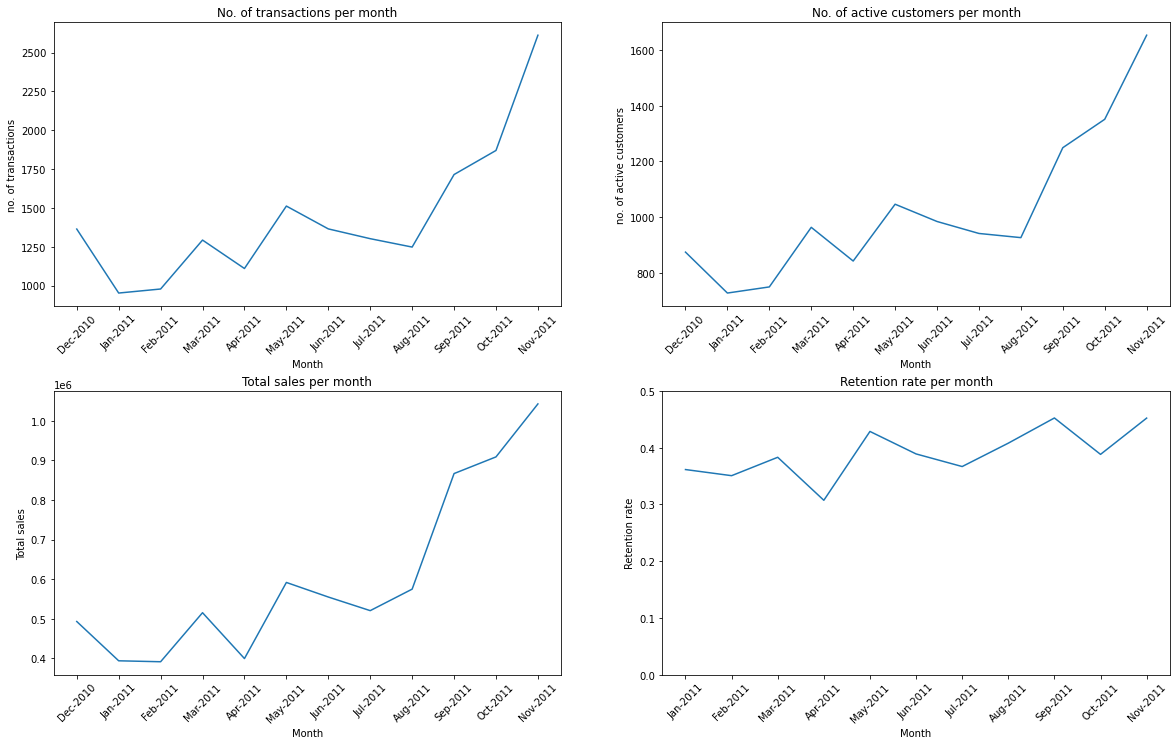

In [264]:
# plotting the no. of transactions per month, no. of active customers per month, 
# total sales per month and retention rate per month

month_analysis.index = ['Jan-2011', 'Feb-2011', 'Mar-2011', 'Apr-2011', 'May-2011', 'Jun-2011', 
                        'Jul-2011', 'Aug-2011', 'Sep-2011', 'Oct-2011', 'Nov-2011', 'Dec-2010']

indexes = [-1] + np.arange (11).tolist ()    # to sort the months in ascending order
month_analysis = month_analysis.iloc [indexes].copy ()

plt.figure (figsize = (20, 12))
plt.subplots_adjust (hspace = 0.3)

# no. of transactions per month
plt.subplot (221)
plt.plot (month_analysis.index, month_analysis.invoice_count)
plt.xlabel ('Month')
plt.ylabel ('no. of transactions')
plt.xticks (rotation = 45)
plt.title ('No. of transactions per month')

# no. of active customers per month
plt.subplot (222)
plt.plot (month_analysis.index, month_analysis.customer_count)
plt.xlabel ('Month')
plt.ylabel ('no. of active customers')
plt.xticks (rotation = 45)
plt.title ('No. of active customers per month')

# total sales per month
plt.subplot (223)
plt.plot (month_analysis.index, month_analysis.revenue)
plt.xlabel ('Month')
plt.ylabel ('Total sales')
plt.xticks (rotation = 45)
plt.title ('Total sales per month')

# retention rate
plt.subplot (224)
plt.plot (month_analysis.index [1:], month_analysis.retention_rate [1:])
plt.xlabel ('Month')
plt.ylabel ('Retention rate')
plt.xticks (rotation = 45)
plt.ylim (0,0.5)
plt.title ('Retention rate per month');

##### Inferences :
    1. We see an upward trend from the Aug 2011 to Nov 2011 for no. transactions, active customers and sales.
    2. The lowest sales are in the month of January, Febrary and April.
    3. We see lowest retention rate in April and highest in September and November.
    4. Considering all the above factors, it seems like April (start of the new financial year) has performed worst.

In [265]:
# saving the cleaned data set to be reused again if required

path2 = 'H:/Documents/Study material/Data Science course/Capstone Project/Project 3 - Retail - PGP/Online Retail2.csv'
retail.to_csv (path2, index = False)

### Step 3: RFM analysis
##### We can now perform the RFM analysis to check which are the most valuable customer. To perform this, we need to -
* aggregate the data customer wise
* calculate their last purchase date (to calculate the recency value)
* count of invoice no./transactions (to calculate the frequency value)
* their total sales (to calculate the monetary value).
* convert last purchase date to no. of days passed since last transaction (to get the value of recency).
* create RFM segments by dividing each RFM value into quartiles.
* score each RFM segment and get total score for each customer.
* analyze the customers in each RFM segment.

In [2]:
# importing the cleaned data

path2 = 'H:/Documents/Study material/Data Science course/Capstone Project/Project 3 - Retail - PGP/Online Retail2.csv'
retail = pd.read_csv (path2, parse_dates = ['InvoiceDate'])

##### the following formula helps find out the RFM values -

- Recency - last invoice date (overall) - max invoice date (per customer ID)
- Frequency - Count of Invoice Numbers (per customer ID)
- Monetary - sum of price (unit price * quantity) (per customer ID)

In [3]:
# grouping the data by customers and getting last invoice date, count of invoice no. and total sales (price)

cust_data = retail.groupby ('CustomerID').agg ({'InvoiceDate' : 'max', 'InvoiceNo' : 'nunique', 
                                                'price' : 'sum', 'Country' : 'unique'})

cust_data.Country = cust_data.Country.apply (lambda x : x [0])
cust_data.head ()

,InvoiceDate,InvoiceNo,price,Country
CustomerID,,,,
12347.0,2011-12-07 15:52:00,7,3653.45,Iceland
12348.0,2011-09-25 13:13:00,4,1437.24,Finland
12349.0,2011-11-21 09:51:00,1,1372.42,Italy
12350.0,2011-02-02 16:01:00,1,258.00,Norway
12352.0,2011-11-03 14:37:00,7,1252.91,Norway


In [4]:
# calculating the column for no. of days passed since last purchase

last_date = cust_data.InvoiceDate.max ()
cust_data ['LastPurchase'] = cust_data.InvoiceDate.apply (lambda x : (last_date - x).days)

# droping the InvoiceDate column, renaming the columns according to RFM values and sorting the columns
cust_data.drop (columns = 'InvoiceDate', inplace = True)
cust_data.rename (columns = {'InvoiceNo' : 'Frequency_value', 
                             'price' : 'Monetary_value', 
                             'LastPurchase' : 'Recency_value'}, inplace = True)

cust_data = cust_data [['Country', 'Recency_value', 'Frequency_value', 'Monetary_value']]
cust_data.head ()

,Country,Recency_value,Frequency_value,Monetary_value
CustomerID,,,,
12347.0,Iceland,1,7,3653.45
12348.0,Finland,74,4,1437.24
12349.0,Italy,18,1,1372.42
12350.0,Norway,309,1,258.00
12352.0,Norway,35,7,1252.91


##### We have created the RFM values for all the customers. We can now create RFM segments. But before that we must check the statistical summary and distribution of each column.

In [5]:
cust_data.describe ()

,Recency_value,Frequency_value,Monetary_value
count,4303.000000,4303.000000,4303.000000
mean,91.944457,4.203347,1761.302733
std,100.507778,7.472421,7820.798825
min,0.000000,1.000000,2.880000
25%,17.000000,1.000000,266.000000
50%,50.000000,2.000000,607.600000
75%,142.500000,5.000000,1465.725000
max,373.000000,197.000000,264746.920000


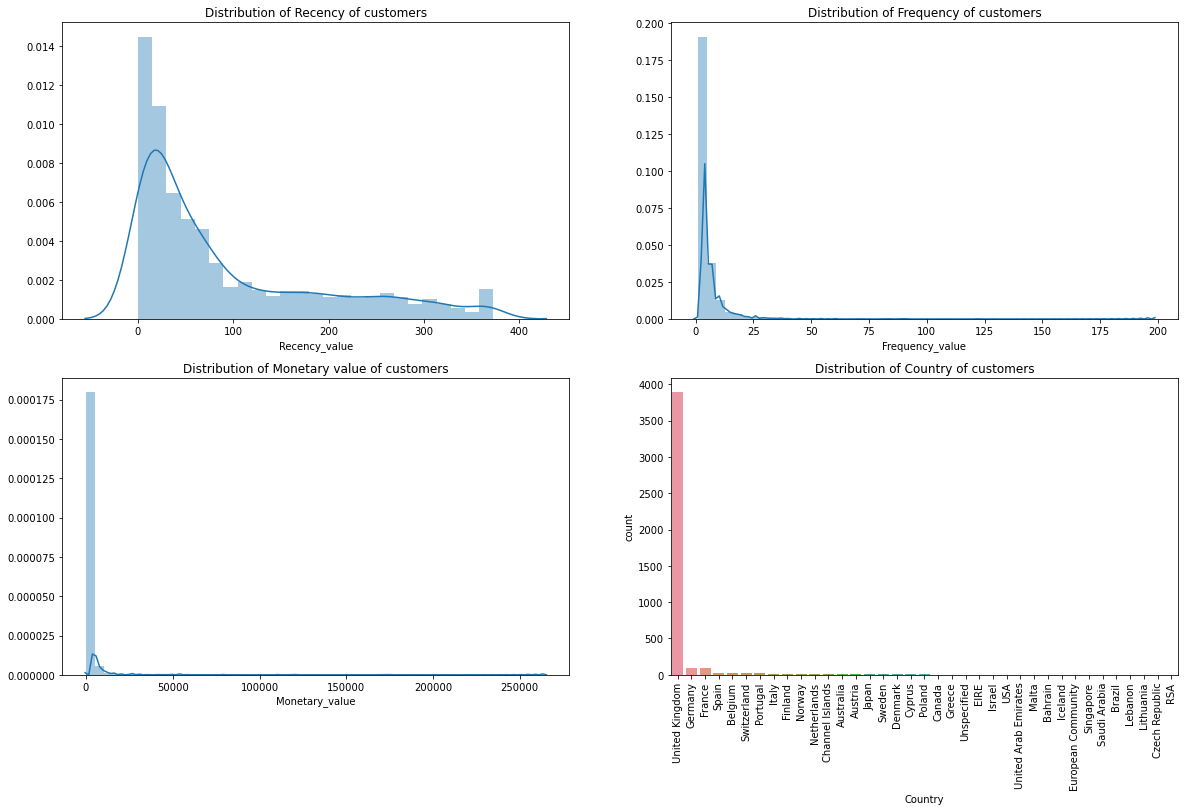

In [6]:
# pltting the disctribution of each variable

plt.figure (figsize = (20, 12))
plt.subplots_adjust (hspace = 0.2)

# distribution of Recency value
plt.subplot (221)
sns.distplot (cust_data.Recency_value)
plt.title ('Distribution of Recency of customers')

# distribution of Frequency value
plt.subplot (222)
sns.distplot (cust_data.Frequency_value)
plt.title ('Distribution of Frequency of customers')

# distribution of Monetary value
plt.subplot (223)
sns.distplot (cust_data.Monetary_value)
plt.title ('Distribution of Monetary value of customers')

# distribution of Countries
plt.subplot (224)
sns.countplot (cust_data.Country, order = cust_data.Country.value_counts ().index)
plt.xticks (rotation = 90)
plt.title ('Distribution of Country of customers');

##### Inferences :
    1. There are 4303 customers in total.
    2. All the variables are highly right skewed.
    3. We wll have to check for some outliers in the data.
    4. We may also need to do proper transformation to handle the skewness of the data.
    5. The data contains most of the customers from UK.

In [7]:
# creating the RFM segments by dividing them into quartiles and rating them
# for columns monetary and frequency, lower value means lower rating and higher means higher rating
# for recency, lower value means higher rating and vice versa

# defining a function to convert the RFM values to ratings
def quartiles (series) :
        
    # finding the first, second and third quartiles of the series
    q1, q2, q3 = series.quantile ([0.25, 0.5, 0.75])

    # defining the ratings according to quartiles
    rating = [4,3,2,1] if series.name == 'Recency_value' else [1,2,3,4]

    # defining the function to convert each value to defined rating according to its quartile
    converter = lambda x : rating [0] if x <= q1 else (rating [1] if x <= q2 \
                                                       else (rating [2] if x <= q3 \
                                                             else rating [3]))
    
    return (series.apply (converter))

# applying the function to RFM columns to convert to ratings
cust_data_rating = cust_data.drop (columns = 'Country').apply (quartiles)

# renaming the columns from value to rating
cust_data_rating.columns = [col [:-6] + '_rating' for col in cust_data_rating.columns]

# concatenating the ratings data frame with the main data frame
cust_data = pd.concat ([cust_data, cust_data_rating], axis = 1)

cust_data.head ()

,Country,Recency_value,Frequency_value,Monetary_value,Recency_rating,Frequency_rating,Monetary_rating
CustomerID,,,,,,,
12347.0,Iceland,1,7,3653.45,4,4,4
12348.0,Finland,74,4,1437.24,2,3,3
12349.0,Italy,18,1,1372.42,3,1,3
12350.0,Norway,309,1,258.00,1,1,1
12352.0,Norway,35,7,1252.91,3,4,3


##### Now, we have got the RFM segments and rated them. Now, we can get the total rating.

In [8]:
# combining the 3 ratings in the form of a string
cust_data ['rating'] = cust_data.iloc [:, 4:].astype (str).apply (lambda x : x.str.cat (sep = '-'), 
                                                                  axis = 1)

# adding the 3 ratings
cust_data ['total_rating'] = cust_data.Recency_rating + cust_data.Frequency_rating + cust_data.Monetary_rating

cust_data.head ()

,Country,Recency_value,Frequency_value,Monetary_value,Recency_rating,Frequency_rating,Monetary_rating,rating,total_rating
CustomerID,,,,,,,,,
12347.0,Iceland,1,7,3653.45,4,4,4,4-4-4,12
12348.0,Finland,74,4,1437.24,2,3,3,2-3-3,8
12349.0,Italy,18,1,1372.42,3,1,3,3-1-3,7
12350.0,Norway,309,1,258.00,1,1,1,1-1-1,3
12352.0,Norway,35,7,1252.91,3,4,3,3-4-3,10


##### Now, that we have got the total ratings, let's analyze the best and the worst customers.
Defining of best and worst customers -
- best customers = customers with total rating of 11, 12
- worst customers = customers with total rating of 3, 4.

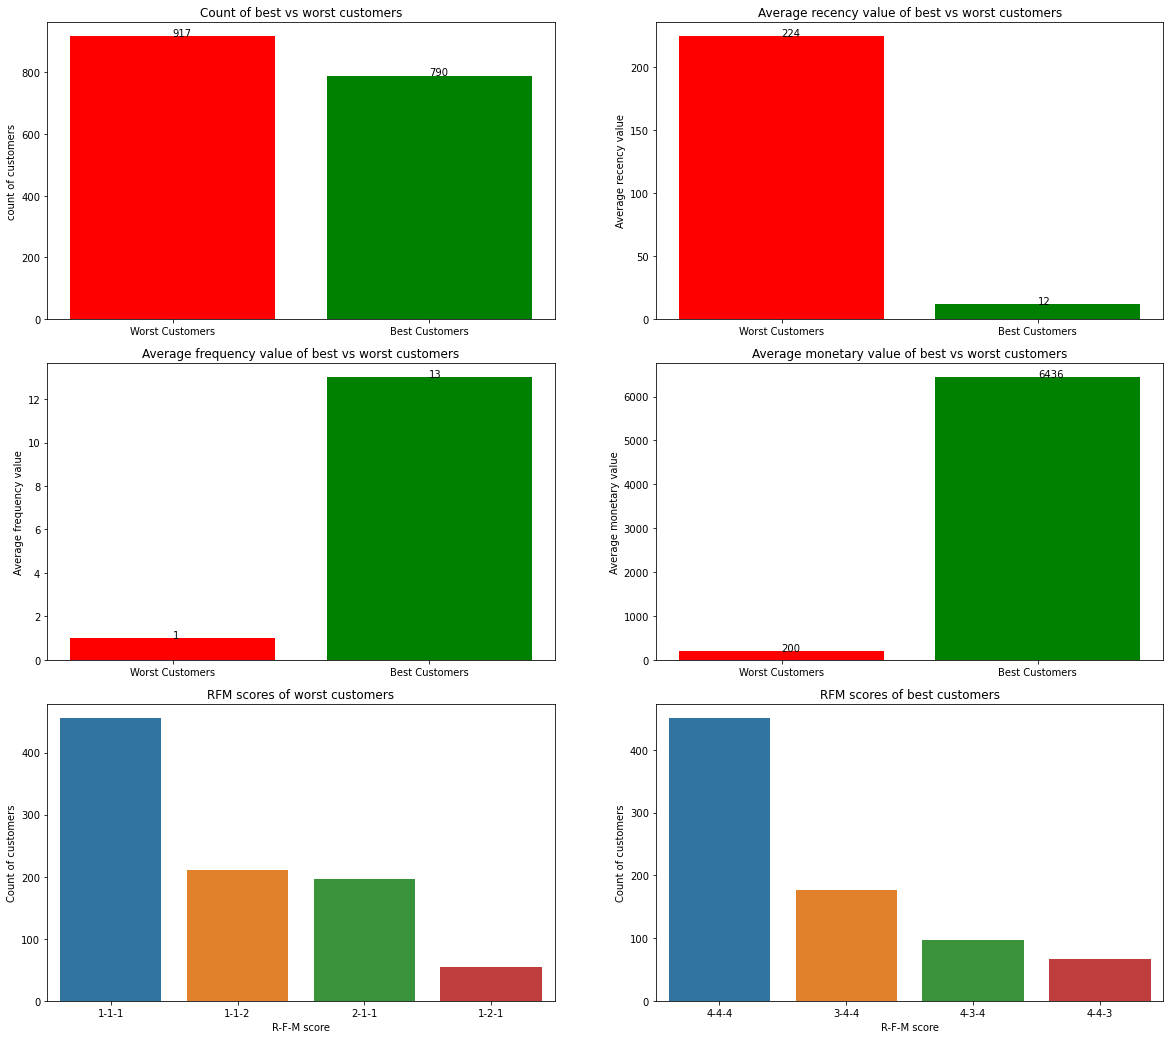

In [9]:
# segregating the data for the best and the worst customer

best = cust_data [cust_data.total_rating.isin ([11,12])]
worst = cust_data [cust_data.total_rating.isin ([3,4])]

xlabels = ['Worst Customers', 'Best Customers']

# Plotting the count, average recency, frequency, monetary values, RFM scores of the worst and the best customers

plt.figure (figsize = (20, 18))
plt.subplots_adjust (hspace = 0.15)

# plot for count
plt.subplot (321)
ylabels = [worst.shape [0], best.shape [0]]
plt.bar (xlabels, ylabels, color = ['r','g'])
plt.xticks (xlabels)
for i in [0,1] :
    plt.annotate (ylabels [i], xy = (i,ylabels [i]))
plt.ylabel ('count of customers')
plt.title ('Count of best vs worst customers')

# plot for recency
plt.subplot (322)
ylabels = [int(round(worst.Recency_value.mean ())), int(round(best.Recency_value.mean ()))]
plt.bar (xlabels, ylabels, color = ['r','g'])
plt.xticks (xlabels)
for i in [0,1] :
    plt.annotate (ylabels [i], xy = (i,ylabels [i]))
plt.ylabel ('Average recency value')
plt.title ('Average recency value of best vs worst customers')

# plot for frequency
plt.subplot (323)
ylabels = [int(round(worst.Frequency_value.mean ())), int(round(best.Frequency_value.mean ()))]
plt.bar (xlabels, ylabels, color = ['r','g'])
plt.xticks (xlabels)
for i in [0,1] :
    plt.annotate (ylabels [i], xy = (i,ylabels [i]))
plt.ylabel ('Average frequency value')
plt.title ('Average frequency value of best vs worst customers')

# plot for monetary
plt.subplot (324)
ylabels = [int(round(worst.Monetary_value.mean ())), int(round(best.Monetary_value.mean ()))]
plt.bar (xlabels, ylabels, color = ['r','g'])
plt.xticks (xlabels)
for i in [0,1] :
    plt.annotate (ylabels [i], xy = (i,ylabels [i]))
plt.ylabel ('Average monetary value')
plt.title ('Average monetary value of best vs worst customers')

# plot for RFM scores for worst customers
plt.subplot (325)
sns.countplot (worst.rating, order = worst.rating.value_counts ().index);
plt.ylabel ('Count of customers')
plt.xlabel ('R-F-M score')
plt.title ('RFM scores of worst customers')

# plot for RFM scores for best customers
plt.subplot (326)
sns.countplot (best.rating, order = best.rating.value_counts ().index);
plt.ylabel ('Count of customers')
plt.xlabel ('R-F-M score')
plt.title ('RFM scores of best customers');

##### Inferences :
    1. Out of total 4303 customers, 917 are the worst customers whereas 790 are the best customers.
    2. The worst customers are inactive since an average of 224 days, whereas the best customers were active
       as recently as 12 days at an average.
    3. The average frequency of orders by worst customers is only 1 as compared to 13 by best customers.
    4. The average sales by worst customers is just over $200 but the average sales by best customers is $6436.
    5. From the plot of RFM score of worst customers, we can see that the frequency score is most responsible
       for making these customers worst.
    6. From the plot of RFM score of best customers, we can see that the monetary score is most responsible
       for making these customers best.
   
Note: The above analysis is done on the basis of the given definition of the worst and the best customers. The above results might change if we change the definitions.

##### Though the above segmentation according to the RFM segments provides some useful insights but the more appropriate way for customer segmentation would be clustering technique.

### Step 4: Customer segmentation using clustering
##### To perform this, we need to -
* perform outlier treatment and feature transformation to handle skewness of the data.
* bring the features to the same scale.
* decide the appropriate number of clusters.
* do customer segmentation using k-means clustering.
* analyze the clusters and draw useful insights.

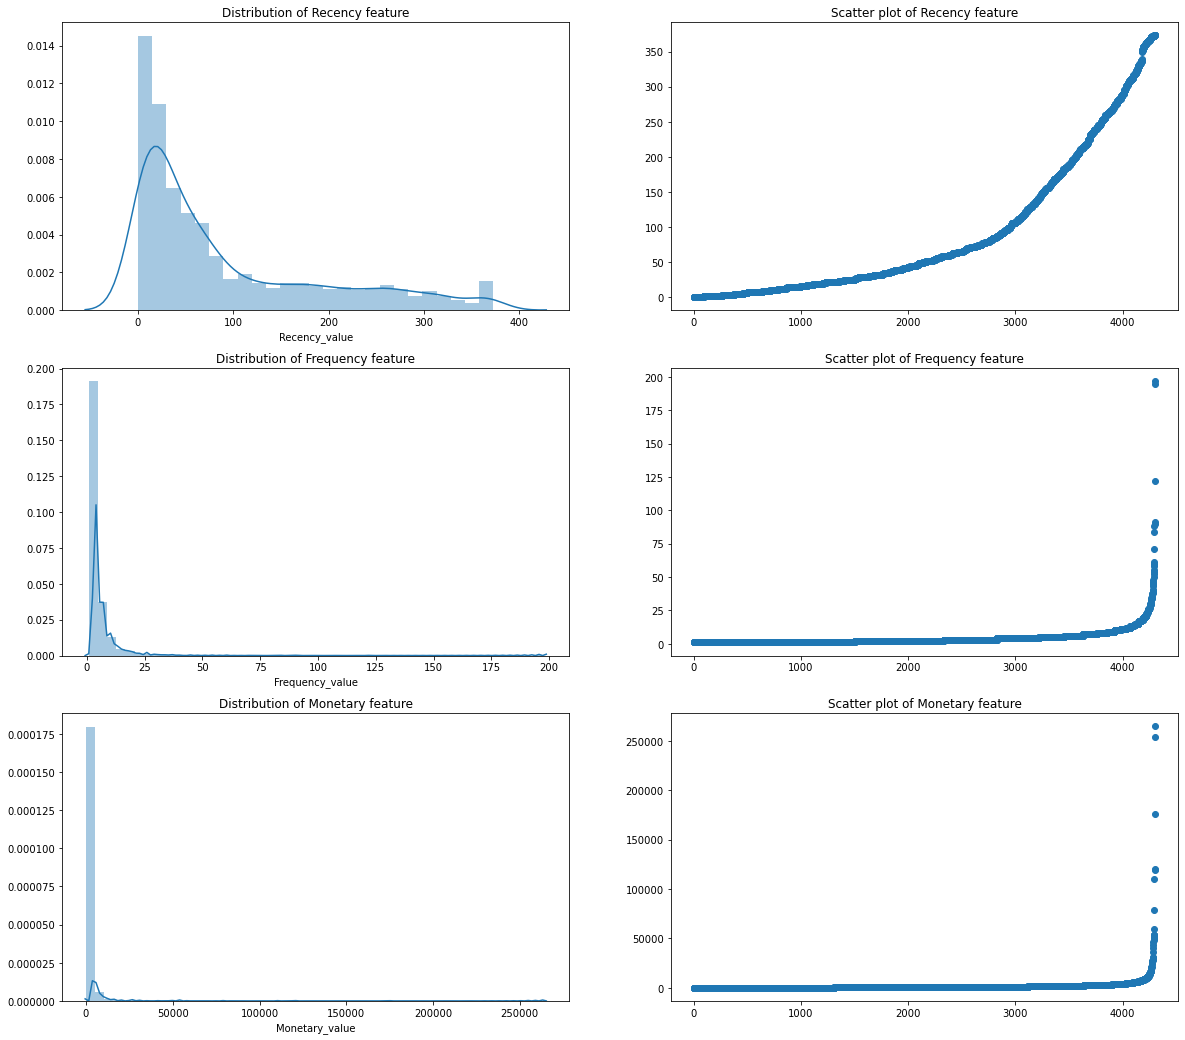

In [10]:
# Let's see the distribution of the RFM features again

plt.figure (figsize = (20,18))

plt.subplot (321)
data = cust_data.Recency_value.sort_values ()
sns.distplot (data)
plt.title ('Distribution of Recency feature')

plt.subplot (322)
plt.scatter (range (data.size), data)
plt.title ('Scatter plot of Recency feature')

plt.subplot (323)
data = cust_data.Frequency_value.sort_values ()
sns.distplot (data)
plt.title ('Distribution of Frequency feature')

plt.subplot (324)
plt.scatter (range (data.size), data)
plt.title ('Scatter plot of Frequency feature')

plt.subplot (325)
data = cust_data.Monetary_value.sort_values ()
sns.distplot (data)
plt.title ('Distribution of Monetary feature')

plt.subplot (326)
plt.scatter (range (data.size), data)
plt.title ('Scatter plot of Monetary feature');

##### Inferences :
    1. All the distributions are highly skewed.
    2. There are some outliers in the frequency and monetary features.
    3. There should not be any need for capping the values.
    4. Now, we need to transform the features to handle the skewness before scaling the features.

In [11]:
# Applying log, cube and boxcox transformation on the columns

def transformation_plots (X) :
    
    ncols = X.shape [1]
    transformations = {}
    for i in range (ncols) :
        col = X.iloc [:,i]
        colname = col.name.split ('_')[0]
        transformations ['{} - Original variable'.format (colname)] = col
        transformations ['{} - Logarithmic transformation'.format (colname)] = np.log (col+1)
        transformations ['{} - Cube root transformation'.format (colname)] = np.cbrt (col)
        transformations ['{} - Yeo Johnson transformation'.format (colname)] = pd.Series (yeojohnson (col)[0])
    
    plt.figure (figsize = (20, 4*ncols))
    plt.subplots_adjust (hspace = 0.3)
    i=1
    
    for name, values in transformations.items () :
        
        plt.subplot (ncols,4,i)
        sns.distplot (values)
        plt.title ('{}\nSkewness = {:.3f}, kurtosis = {:.3f}'.format (name, values.skew (), kurtosis (values)))
        plt.xlabel ('')
        i+=1
    
    plt.show ()

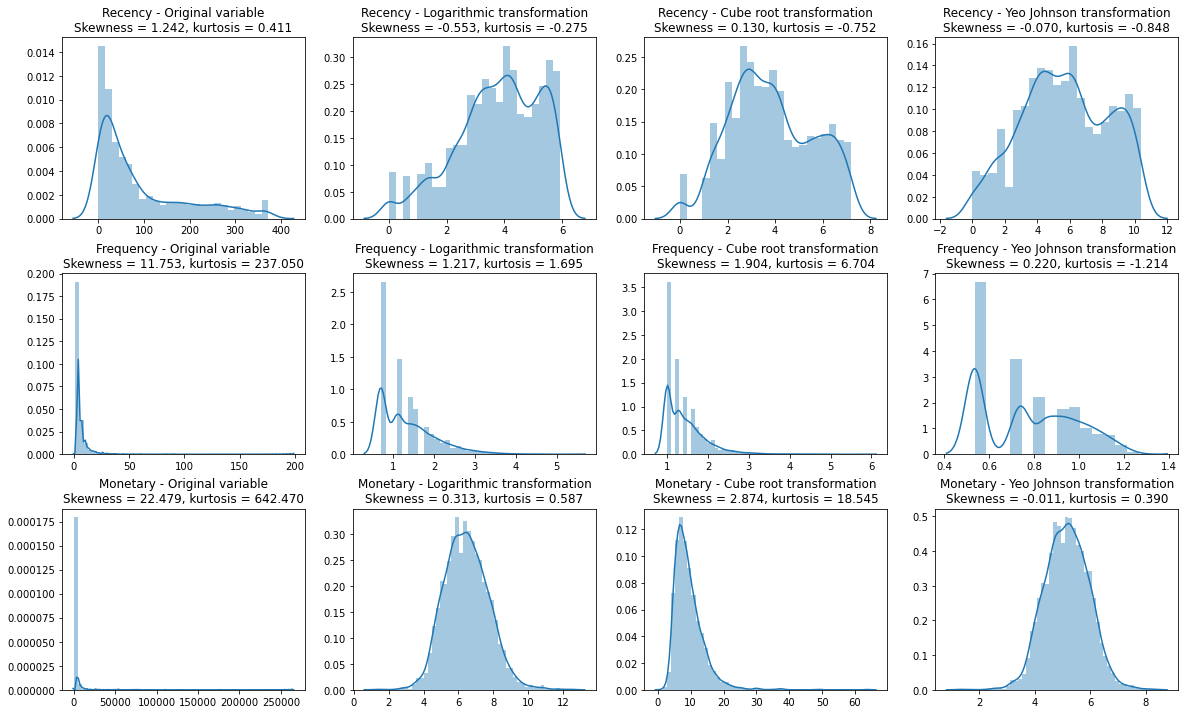

In [12]:
transformation_plots (cust_data [['Recency_value', 'Frequency_value', 'Monetary_value']])

##### We can see that the yeojohson transformation works best for these features. We will use it to handle the skewness of the features.

In [13]:
# transforming the features by applying yeo johnson transformation

cust_data ['Recency_tr'] = yeojohnson (cust_data.Recency_value) [0]
cust_data ['Frequency_tr'] = yeojohnson (cust_data.Frequency_value) [0]
cust_data ['Monetary_tr'] = yeojohnson (cust_data.Monetary_value) [0]

##### Now that we have handled the skewness in the data, let's scale the data using standard scaler.

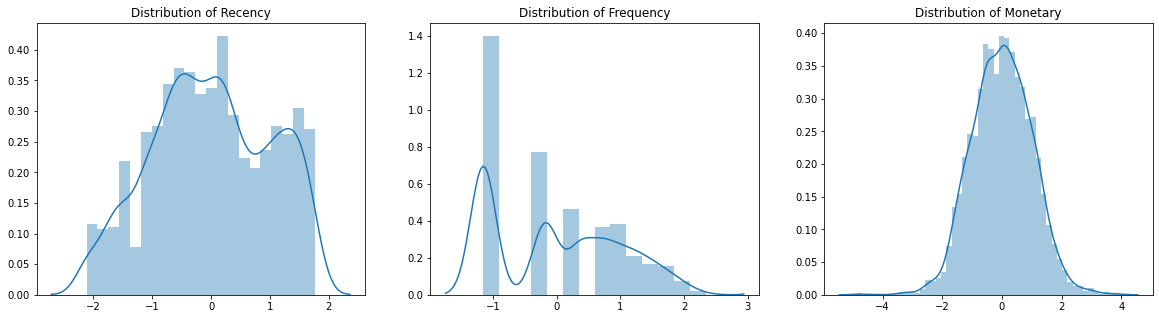

In [14]:
# Scaling of the features

sc = StandardScaler ()
features = sc.fit_transform (cust_data [['Recency_tr', 'Frequency_tr', 'Monetary_tr']])

names = ['Recency', 'Frequency', 'Monetary']
plt.figure (figsize=(20,5))

for i, name in enumerate (names) :
    plt.subplot (1,3,i+1)
    sns.distplot (features [:,i])
    plt.title ('Distribution of {}'.format (name));

##### Now, we need to find out the optimum number of clusters.
We can do that by analyzing scree plot of the within clusters sum of squared error and the silhouette score.

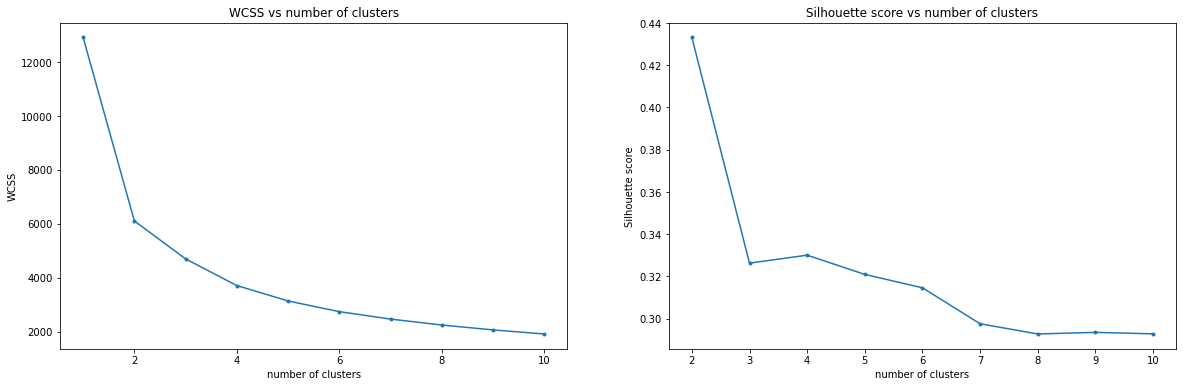

In [15]:
# ploting the within clusters SSE and silhouette score

wcss = []
sil_score = []
n_clusters = np.arange (1,11)
for k in n_clusters :
    km = KMeans (n_clusters=k).fit (features)
    wcss.append (km.inertia_)
    labels = km.predict (features)
    if k > 1 :
        sil_score.append (silhouette_score (features, labels))

    
plt.figure (figsize=(20,6))
plt.subplot (121)
plt.plot (n_clusters, wcss, marker = '.')
plt.xlabel ('number of clusters')
plt.ylabel ('WCSS')
plt.title ('WCSS vs number of clusters')

plt.subplot (122)
plt.plot (n_clusters[1:], sil_score, marker = '.')
plt.xlabel ('number of clusters')
plt.ylabel ('Silhouette score')
plt.title ('Silhouette score vs number of clusters');

##### Inferences :
    1. The scree plot of WCSS shows, optimum number of clusters to ve either 2 or 4.
    2. The silhouette coefficent is clearly identifies the optimum number of clusters as 2.
Hence, the optimum number of clusters should be 2.

In [16]:
# perorming clustering
km = KMeans (n_clusters = 2)
km.fit (features)

# getting the labels and adding to the data set
labels = km.labels_
cust_data ['cluster_no'] = labels+1

# separating the data for each clusters for further analysis
cluster1 = cust_data [cust_data.cluster_no == 1]
cluster2 = cust_data [cust_data.cluster_no == 2]

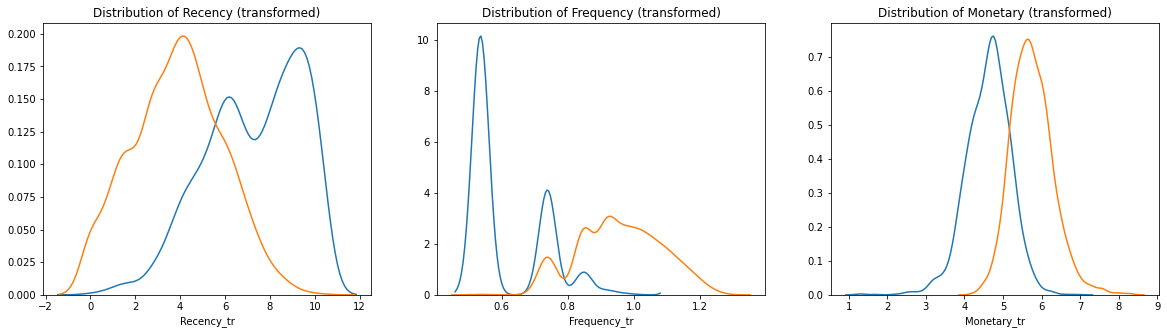

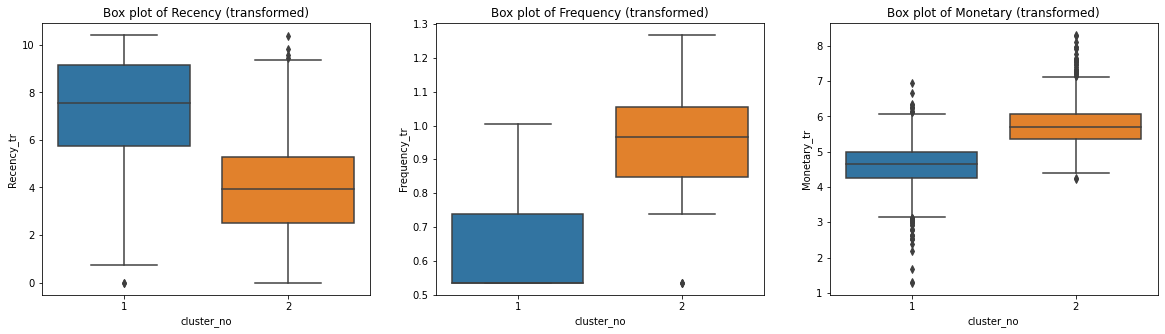

In [17]:
# Let's check how separate the clusters are, using the features created

plt.figure (figsize=(20,5))

# Distribution of Recency
plt.subplot (131)
sns.distplot (cluster1.Recency_tr, hist=False)
sns.distplot (cluster2.Recency_tr, hist=False)
plt.title ('Distribution of Recency (transformed)')

# Distribution of Frequency
plt.subplot(132)
sns.distplot (cluster1.Frequency_tr, hist=False)
sns.distplot (cluster2.Frequency_tr, hist=False)
plt.title ('Distribution of Frequency (transformed)')

# Distribution of Monetary
plt.subplot(133)
sns.distplot (cluster1.Monetary_tr, hist=False)
sns.distplot (cluster2.Monetary_tr, hist=False)
plt.title ('Distribution of Monetary (transformed)');

plt.figure (figsize=(20,5))

# box plot of Recency
plt.subplot (131)
sns.boxplot (cust_data.cluster_no, cust_data.Recency_tr)
plt.title ('Box plot of Recency (transformed)')

# ploting the Frequency vs Monetary
plt.subplot(132)
sns.boxplot (cust_data.cluster_no, cust_data.Frequency_tr)
plt.title ('Box plot of Frequency (transformed)')

# ploting the Recency vs Monetary
plt.subplot(133)
sns.boxplot (cust_data.cluster_no, cust_data.Monetary_tr)
plt.title ('Box plot of Monetary (transformed)');

##### We can see that the transformed features are well separated. Hence, we have obtained robust clusters.
Let's also analyze the actual RFM metrics.

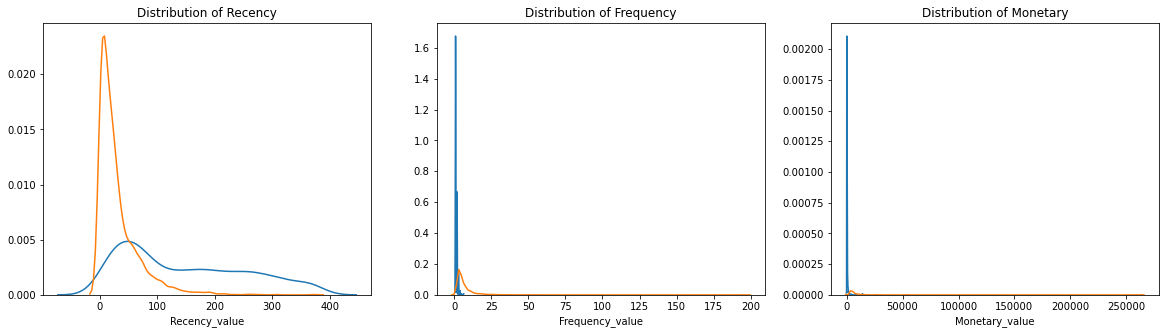

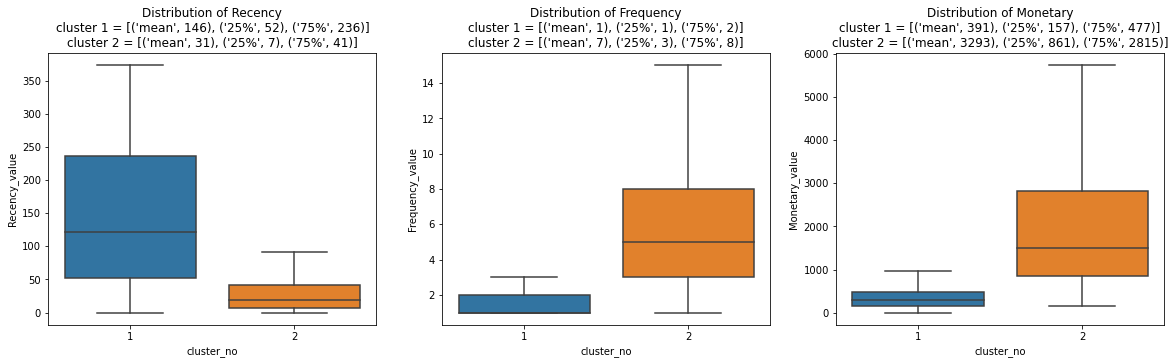

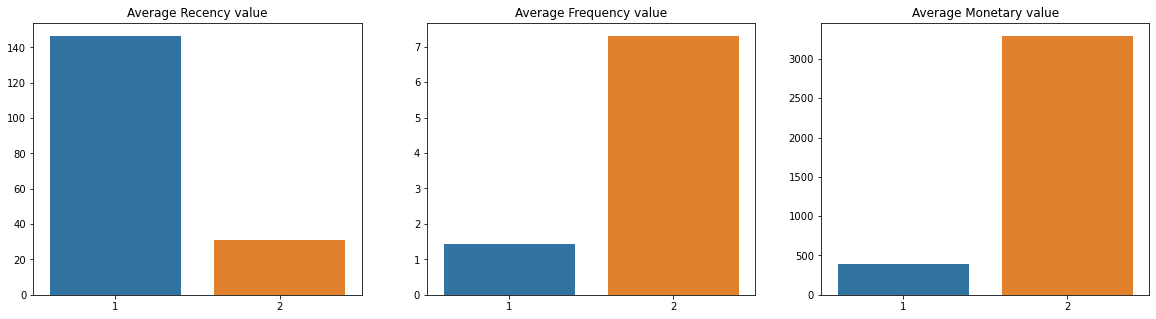

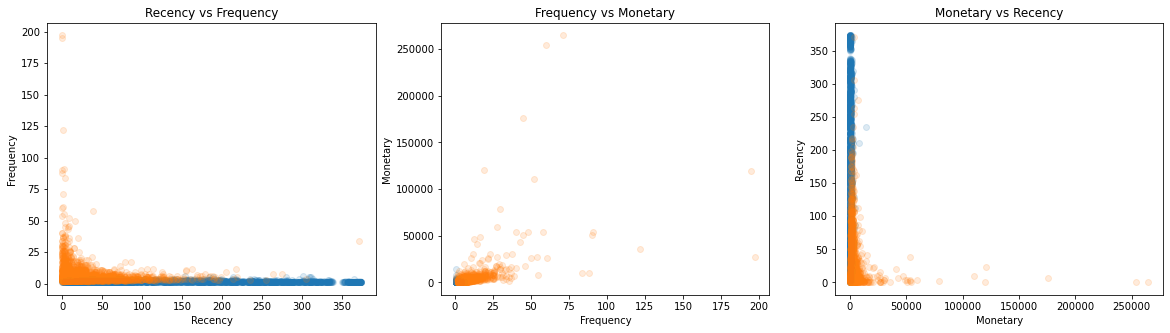

In [18]:
# Analyzing distribution of actual RFM values

cols = ['Recency_value', 'Frequency_value', 'Monetary_value']
plt.figure (figsize=(20,5))

for i,col in enumerate (cols) :
    plt.subplot (1,3,i+1)
    sns.distplot (cluster1 [col], hist=False)
    sns.distplot (cluster2 [col], hist=False)
    plt.title ('Distribution of {}'.format (col.split ('_')[0]));

# Analyzing of actual RFM values using box and whisker plot

desc1 = cluster1.describe ()
desc2 = cluster2.describe ()

plt.figure (figsize=(20,5))

for i,col in enumerate (cols) :
    plt.subplot (1,3,i+1)
    values1 = desc1 [col]
    values2 = desc2 [col]
    values1 = [(index, int (round (val))) for index, val in zip (values1.index, values1.values) \
               if index in ('mean', '25%', '75%')]
    values2 = [(index, int (round (val))) for index, val in zip (values2.index, values2.values) \
               if index in ('mean', '25%', '75%')]
    sns.boxplot (cust_data.cluster_no, cust_data [col], showfliers = False)
    colname = col.split ('_')[0]
    plt.title ('Distribution of {}\ncluster 1 = {}\ncluster 2 = {}'.format (colname, values1, values2));

# Analyzing average RFM values

plt.figure (figsize=(20,5))

for i,col in enumerate (cols) :
    plt.subplot (1,3,i+1)
    sns.barplot ([1,2], [desc1.loc ['mean', col], desc2.loc ['mean', col]])
    plt.title ('Average {} value'.format (col.split ('_')[0]));

# Analyzing the clusters using each pair of variables

cols2 = ['Frequency_value', 'Monetary_value', 'Recency_value']
plt.figure (figsize=(20,5))

for i,col1,col2 in zip (range (3), cols, cols2) :
    plt.subplot (1,3,i+1)
    plt.scatter (cluster1 [col1], cluster1[col2], alpha = 0.15)
    plt.scatter (cluster2 [col1], cluster2 [col2], alpha = 0.15)
    col1_name = col1.split ('_')[0]
    col2_name = col2.split ('_')[0]
    plt.xlabel (col1_name)
    plt.ylabel (col2_name)
    plt.title ('{} vs {}'.format (col1_name,col2_name));

##### Inferences :
    1. From the distributions of recency frequency and monetary values, we can say that the cluster #2 contains
       valuable customers.
    2. The valuable clusters have average recency, frequency and monetary value of 31, 7 and 3320 respectively
       as compared to average recency, frequency and monetary value of 146, 1, 393 respectively for cluster 2.
    3. The recency, frequency and monetary values of customers in the 2 clusters are well separated.
    4. The pair wise comparison of the features cannot be visualized properly due to high skewness.
    5. Though the above analysis clearly distinguishes between valuable and average customers but looking at the
       pairwise comparison of variables, there are lots of outliers in cluster #2.
##### Instead of just separating the valuable customers from average customers, we can create 3 clusters so that VIP customer are also clearly identified.

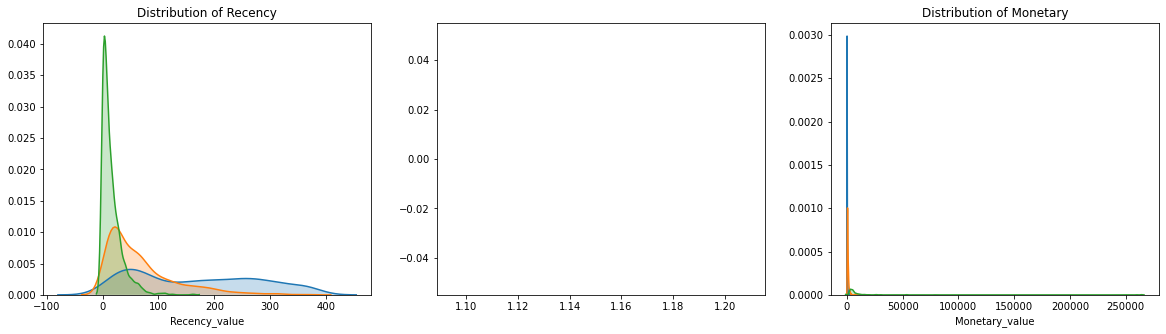

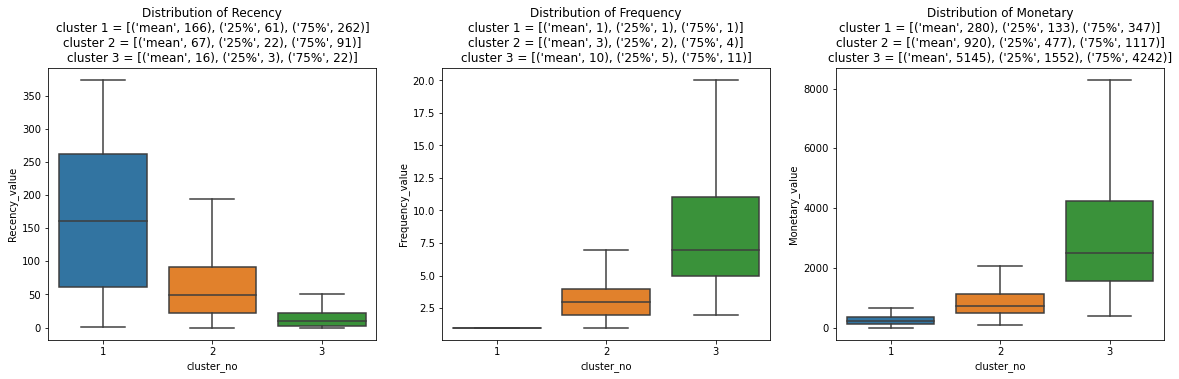

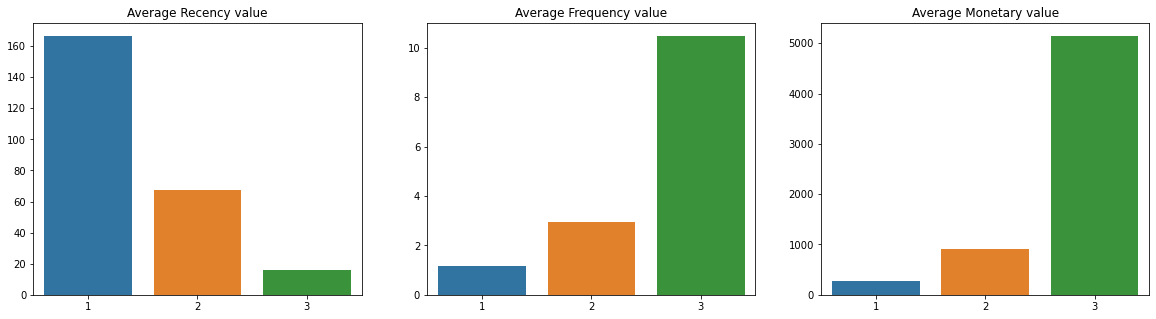

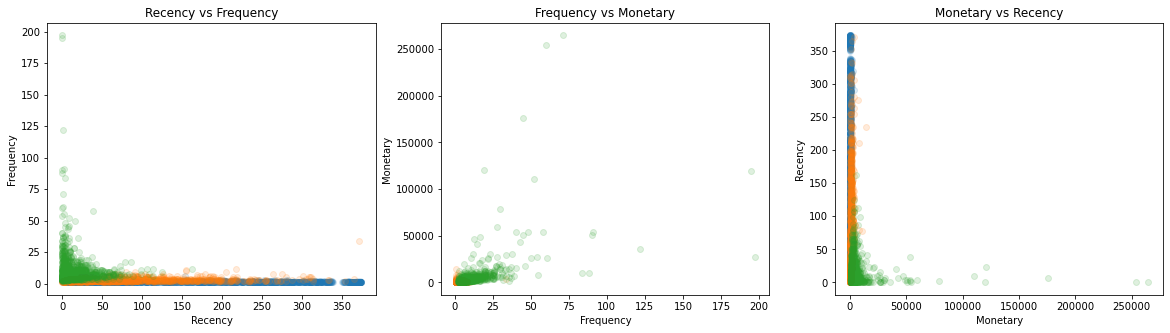

In [19]:
# creating 3 clusters

km = KMeans (n_clusters = 3)
km.fit (features)
labels = km.labels_
cust_data ['cluster_no'] = labels+1
cluster1 = cust_data [cust_data.cluster_no == 1]
cluster2 = cust_data [cust_data.cluster_no == 2]
cluster3 = cust_data [cust_data.cluster_no == 3]

# Analyzing distribution of actual RFM values

cols = ['Recency_value', 'Frequency_value', 'Monetary_value']
plt.figure (figsize=(20,5))

for i,col in enumerate (cols) :
    plt.subplot (1,3,i+1)
    try :
        sns.distplot (cluster1 [col], hist=False, kde_kws={'shade':True})
    except :
        continue
    try :
        sns.distplot (cluster2 [col], hist=False, kde_kws={'shade':True})
    except :
        continue
    sns.distplot (cluster3 [col], hist=False, kde_kws={'shade':True})
    plt.title ('Distribution of {}'.format (col.split ('_')[0]));

# Analyzing of actual RFM values using box and whisker plot

desc1 = cluster1.describe ()
desc2 = cluster2.describe ()
desc3 = cluster3.describe ()

plt.figure (figsize=(20,5))

for i,col in enumerate (cols) :
    plt.subplot (1,3,i+1)
    values1, values2, values3 = desc1 [col], desc2 [col], desc3 [col]
    values1 = [(index, int (round (val))) for index, val in zip (values1.index, values1.values) \
               if index in ('mean', '25%', '75%')]
    values2 = [(index, int (round (val))) for index, val in zip (values2.index, values2.values) \
               if index in ('mean', '25%', '75%')]
    values3 = [(index, int (round (val))) for index, val in zip (values3.index, values3.values) \
               if index in ('mean', '25%', '75%')]
    sns.boxplot (cust_data.cluster_no, cust_data [col], showfliers = False)
    colname = col.split ('_')[0]
    plt.title ('Distribution of {}\ncluster 1 = {}\ncluster 2 = {}\ncluster 3 = {}'\
               .format (colname, values1, values2, values3));

# Analyzing average RFM values

plt.figure (figsize=(20,5))

for i,col in enumerate (cols) :
    plt.subplot (1,3,i+1)
    sns.barplot ([1,2,3], [desc1.loc ['mean', col], desc2.loc ['mean', col], desc3.loc ['mean', col]])
    plt.title ('Average {} value'.format (col.split ('_')[0]));

# Analyzing the clusters using each pair of variables

cols2 = ['Frequency_value', 'Monetary_value', 'Recency_value']
plt.figure (figsize=(20,5))

for i,col1,col2 in zip (range (3), cols, cols2) :
    plt.subplot (1,3,i+1)
    plt.scatter (cluster1 [col1], cluster1[col2], alpha = 0.15)
    plt.scatter (cluster2 [col1], cluster2 [col2], alpha = 0.15)
    plt.scatter (cluster3 [col1], cluster3 [col2], alpha = 0.15)
    col1_name = col1.split ('_')[0]
    col2_name = col2.split ('_')[0]
    plt.xlabel (col1_name)
    plt.ylabel (col2_name)
    plt.title ('{} vs {}'.format (col1_name,col2_name));

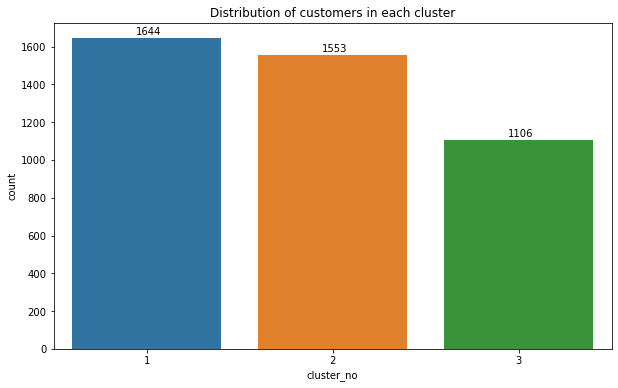

In [20]:
# checking the distribution of customers in each cluster

plt.figure (figsize=(10,6))
sns.countplot (cust_data.cluster_no);
data = cust_data.cluster_no.value_counts (sort=False)
for i,count in enumerate (data) :
    plt.annotate (count, xy = (i-0.06, count+20))
plt.title ('Distribution of customers in each cluster');

##### Inferences :
    1. From the graphs above, we clearly distiguishes the VIP customers which fall in cluster #3.
    2. The average recency, frequency and monetary values of VIP customers is 16, 10 and $5145 respectively,
       which is way better than the customers in other 2 clusters.
    3. The number of VIP customers are 1106.
    4. The customers in cluster #1 are non-valuable customers whereas in cluster #2 are average customers.
Now, that we have found the VIP customers (cluster #3), we can offer them discounts and special offers as needed.

### Step 5 : Final Exporatory Data Analysis
We will perform some more EDA using tableau for that we will -
- export the customer wise data on which we performed clustering.
- create and export the number of clusters with corresponding error (within cluster sum of squared error).
- import the data in tableau and perform the following analysis -
    
    1. Country-wise average spend.
    2. top 15 products most sold.
    3. hourly count of orders.
    4. distribution of RFM values.
    5. error (cost) vs. number of clusters
    6. comparison of RFM values of the clusters.

In [26]:
# Exporting the customer wise data

path3 = 'H:/Documents/Study material/Data Science course/Capstone Project/Project 3 - Retail - PGP/Retail clustered.csv'
cust_data.reset_index ().to_csv (path3, index = False)

In [92]:
# creating and exporting the number of clusters with errors

clusters_error = pd.DataFrame ({'n_clusters' : n_clusters, 'error' : wcss})
display (clusters_error)
path4 = 'H:/Documents/Study material/Data Science course/Capstone Project/Project 3 - Retail - PGP/Retail cluster error.csv'
clusters_error.to_csv (path4, index = False)

,n_clusters,error
0,1,12909.000000
1,2,6107.239595
2,3,4701.957016
3,4,3713.246404
4,5,3142.720596
5,6,2745.983437
6,7,2471.145236
7,8,2250.349135
8,9,2069.286639
9,10,1920.784665


##### Dashboard 1 (showing country wise data)
ALL COUNTRIES
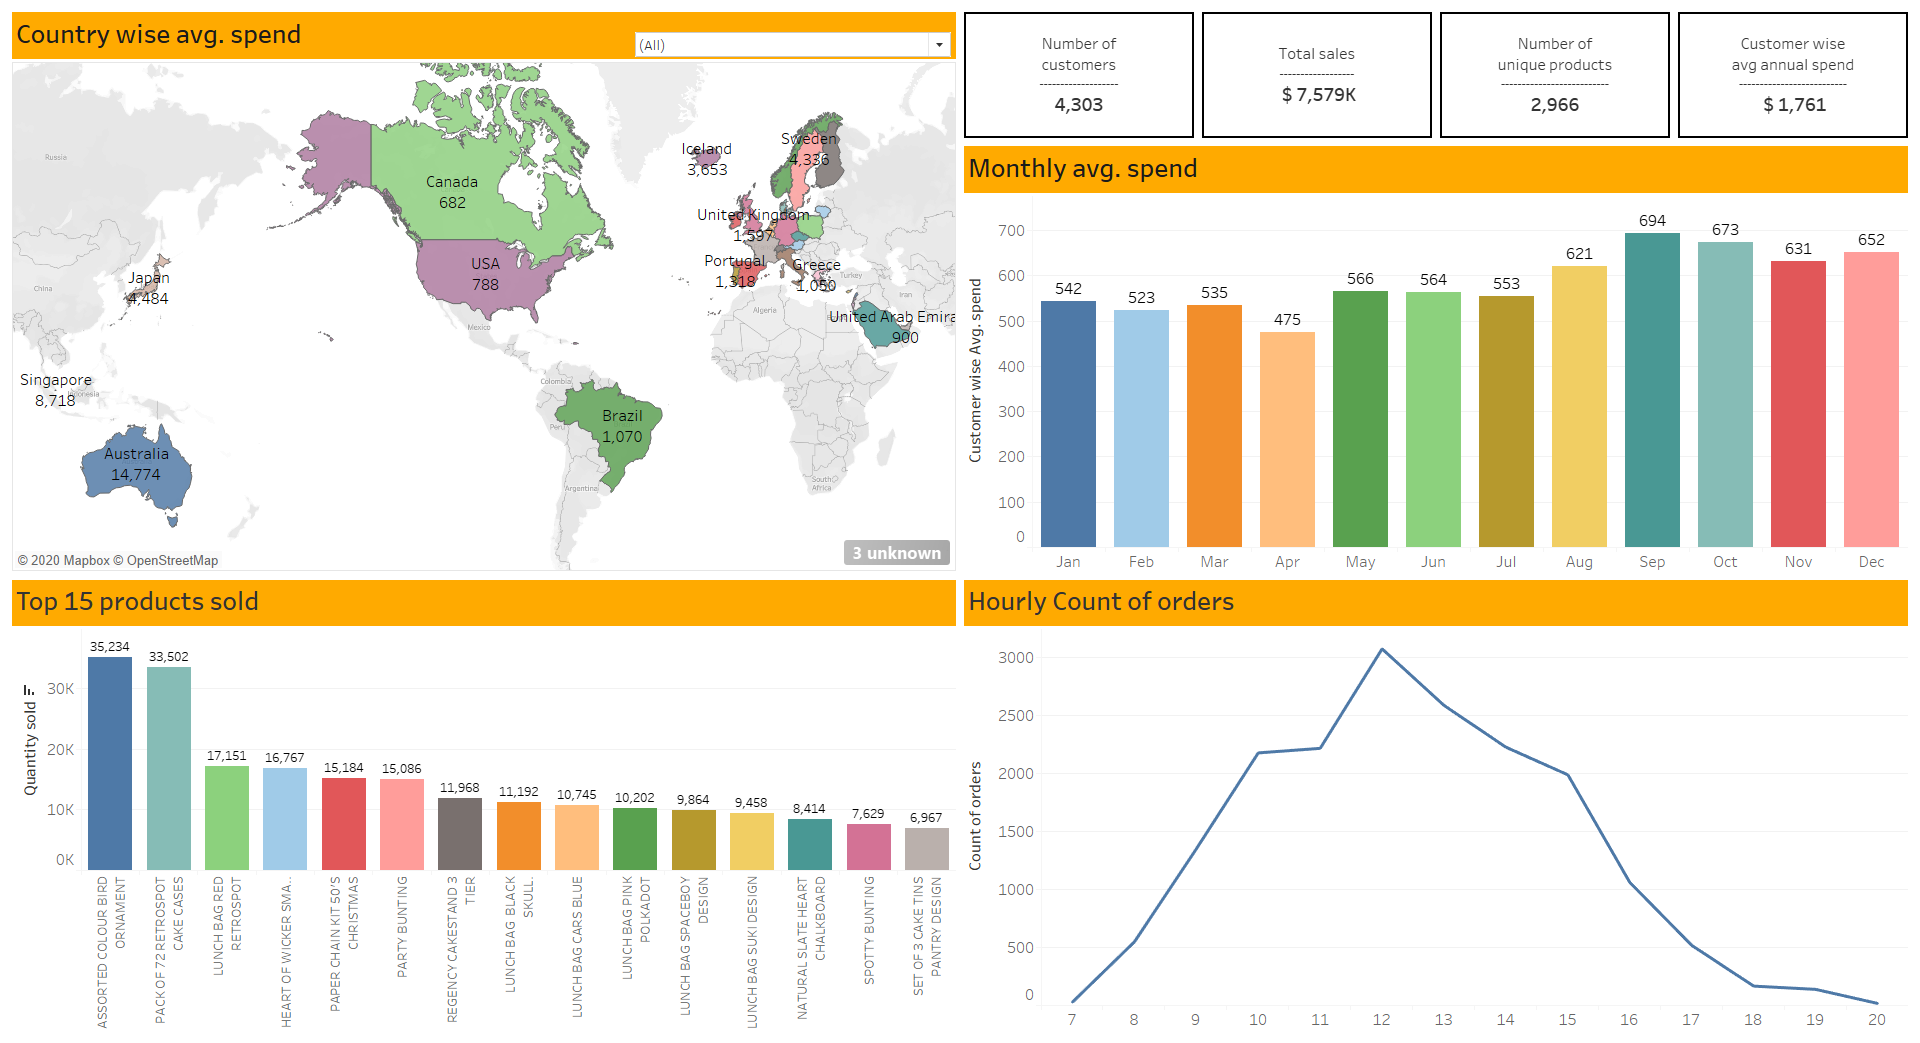

UK
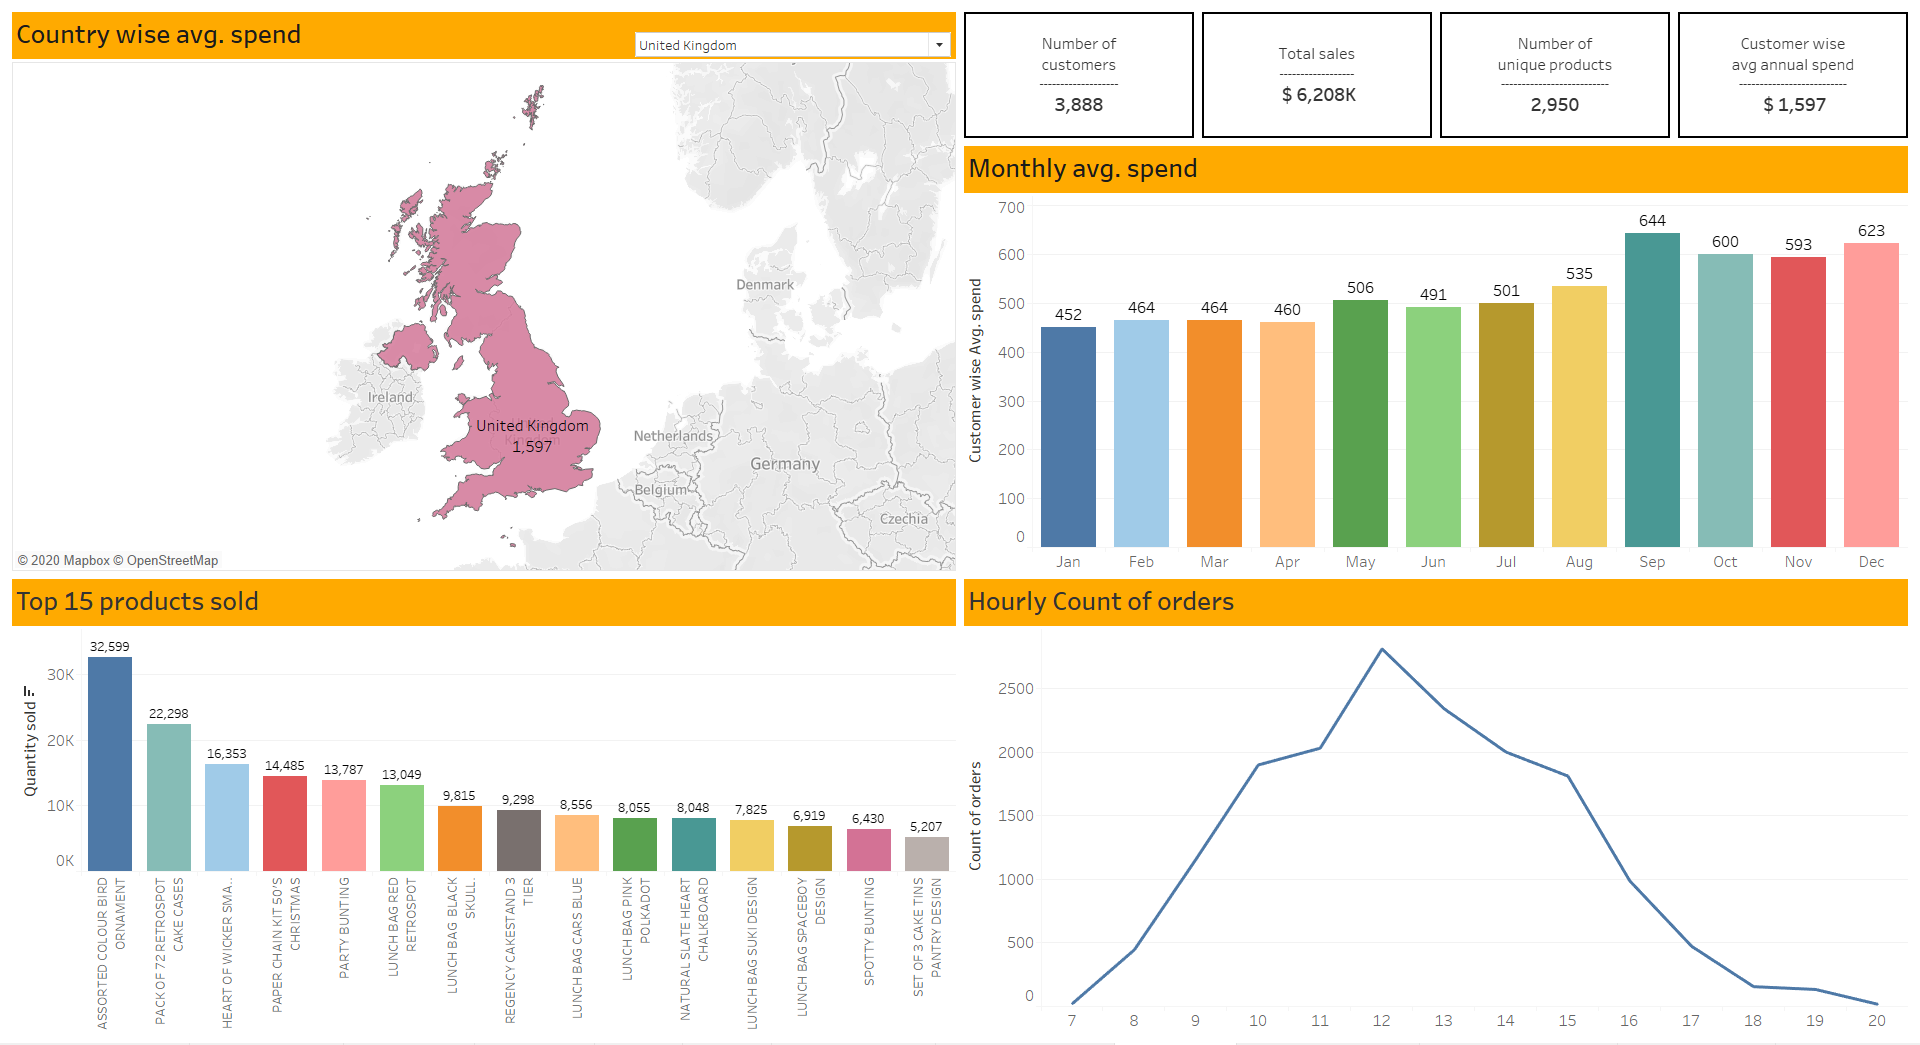

AUSTRALIA
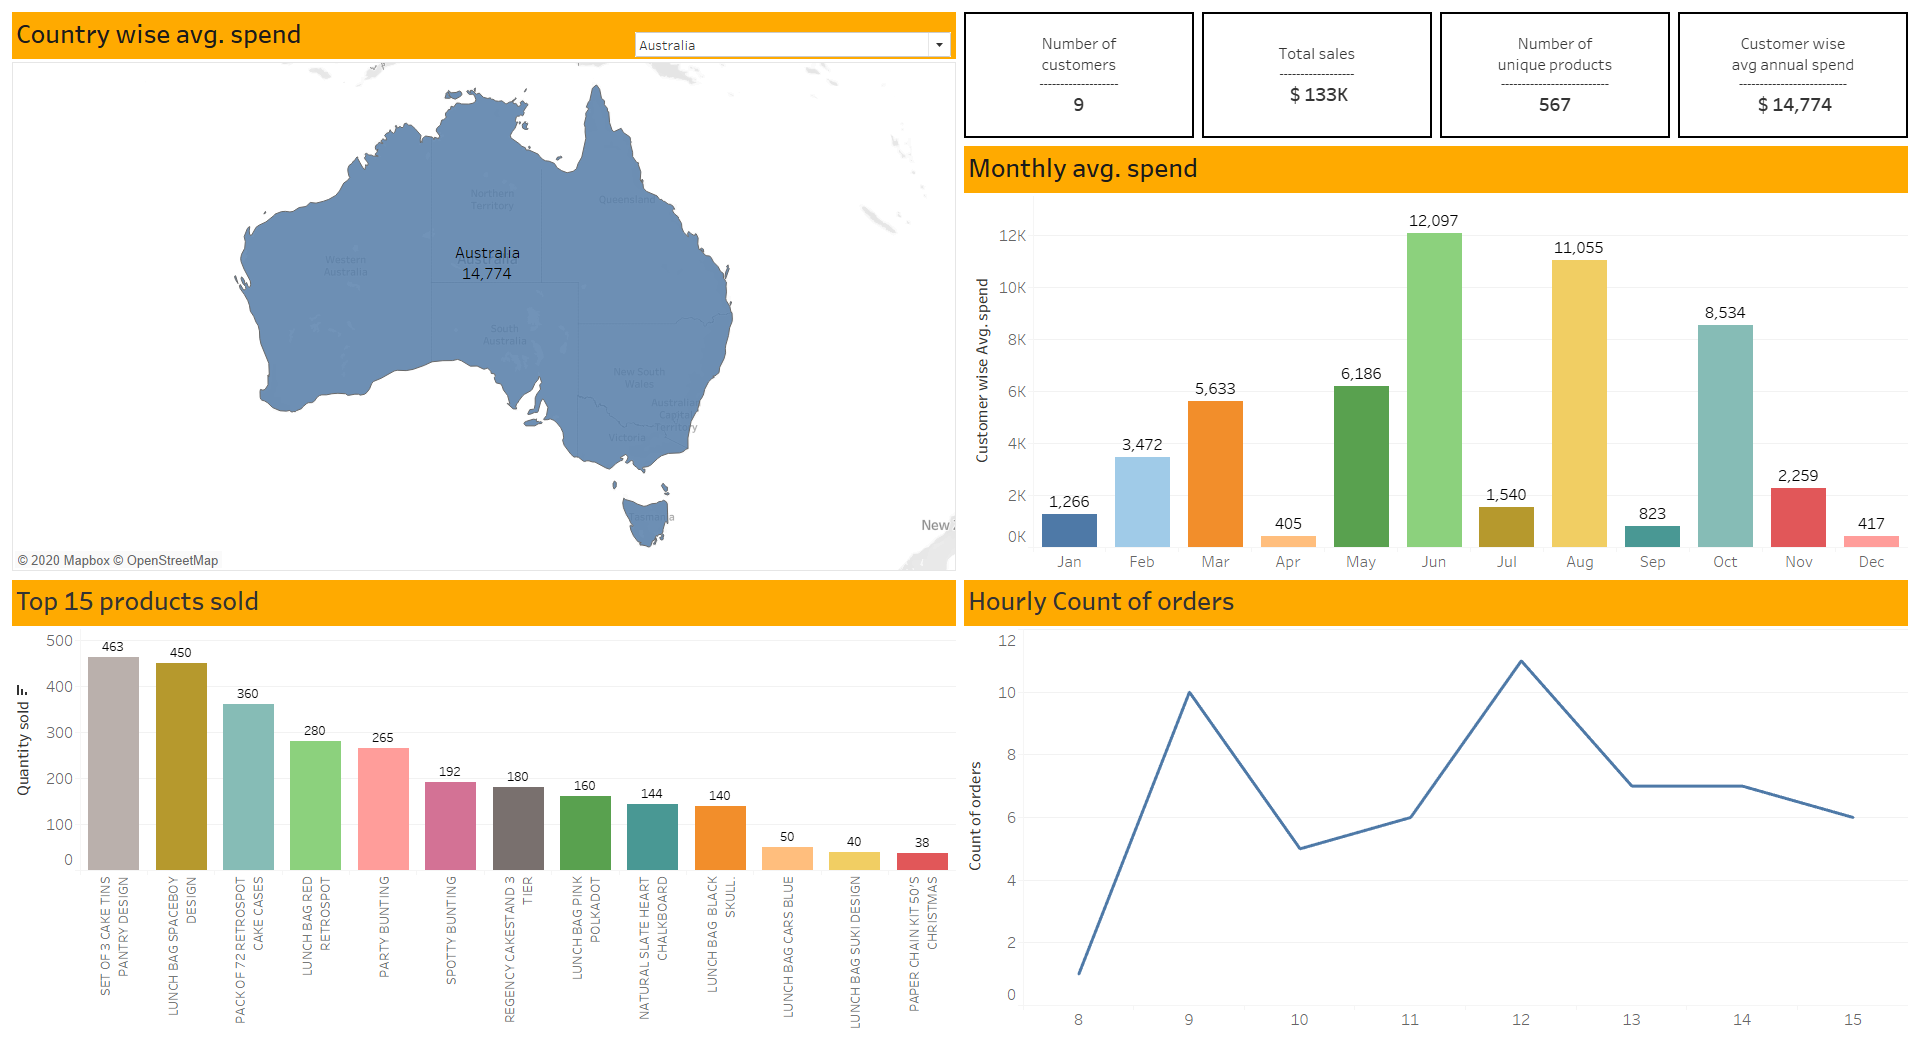

SWITZERLAND
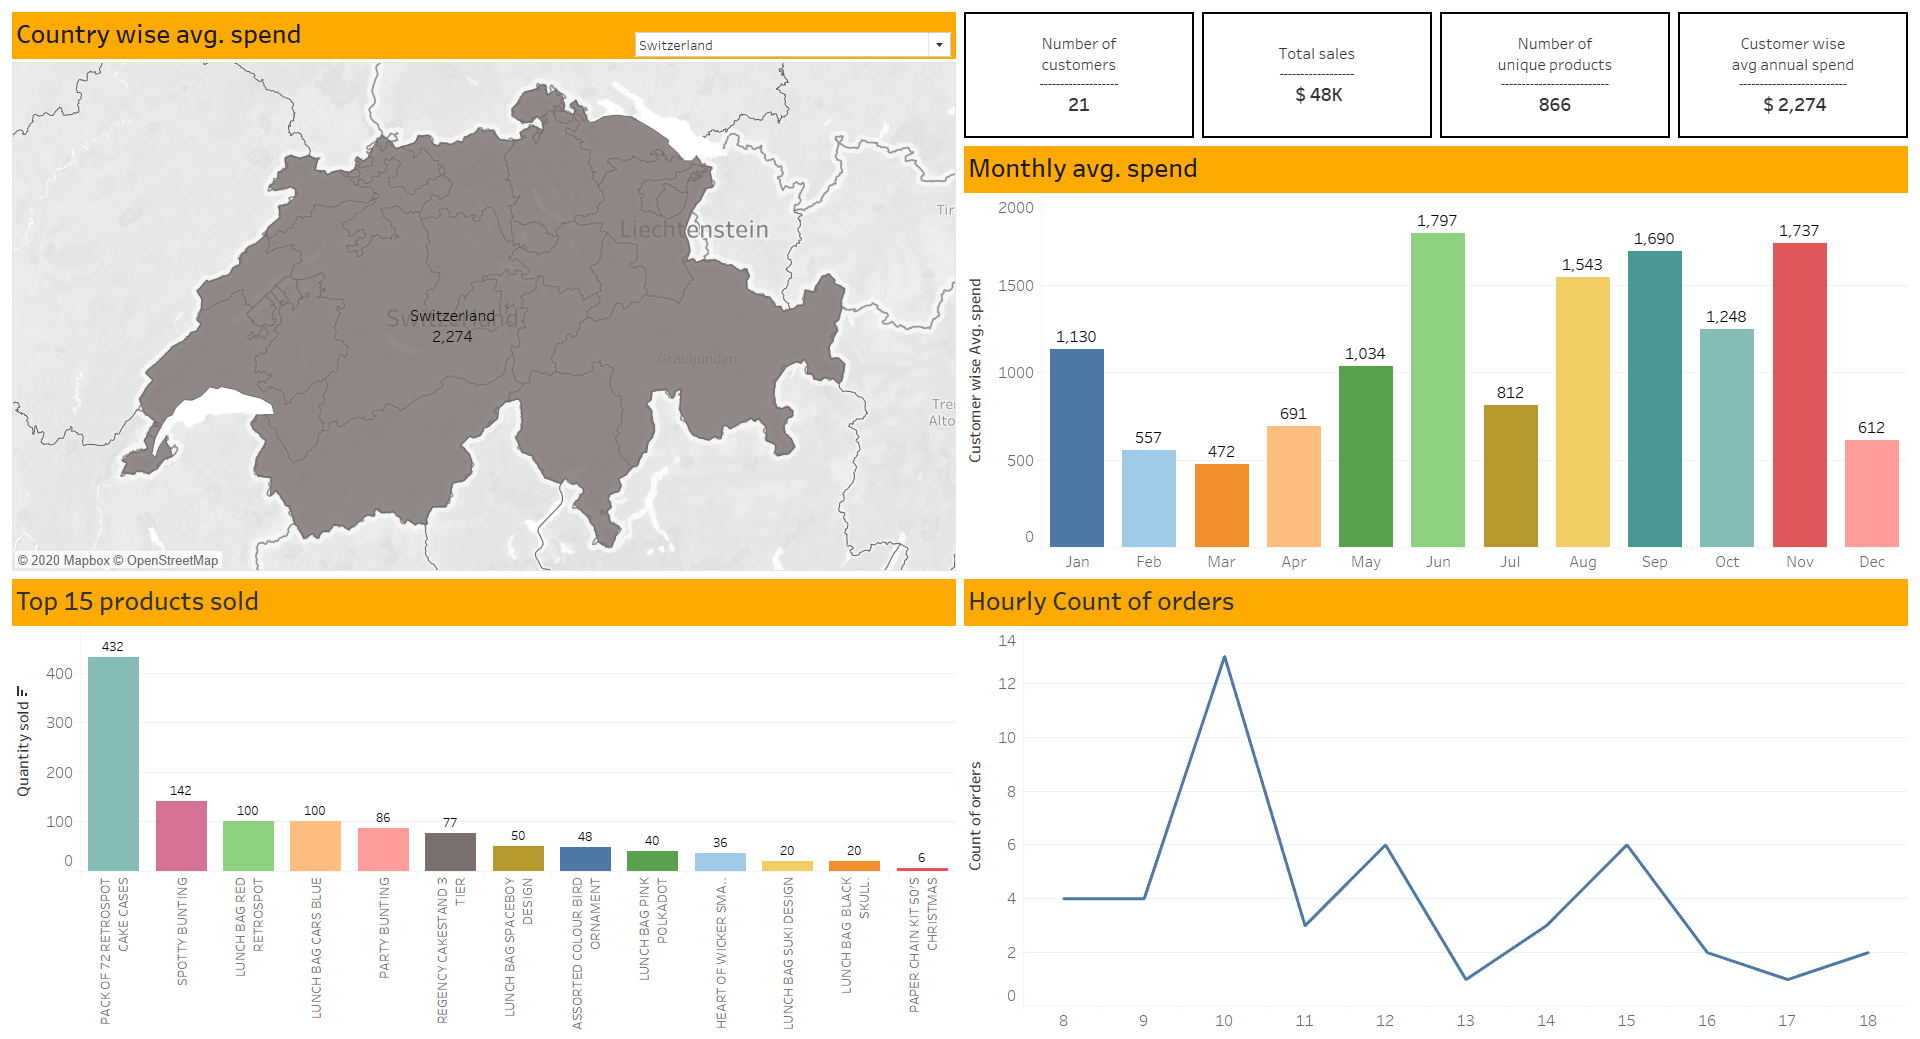

Please open the above dashboard using the following tableau profile link -

https://public.tableau.com/profile/sahaj.harnal#!/vizhome/Project1-RetailPGP/CountrywiseDashboard

##### Dashboard 2 (RFM Analysis)
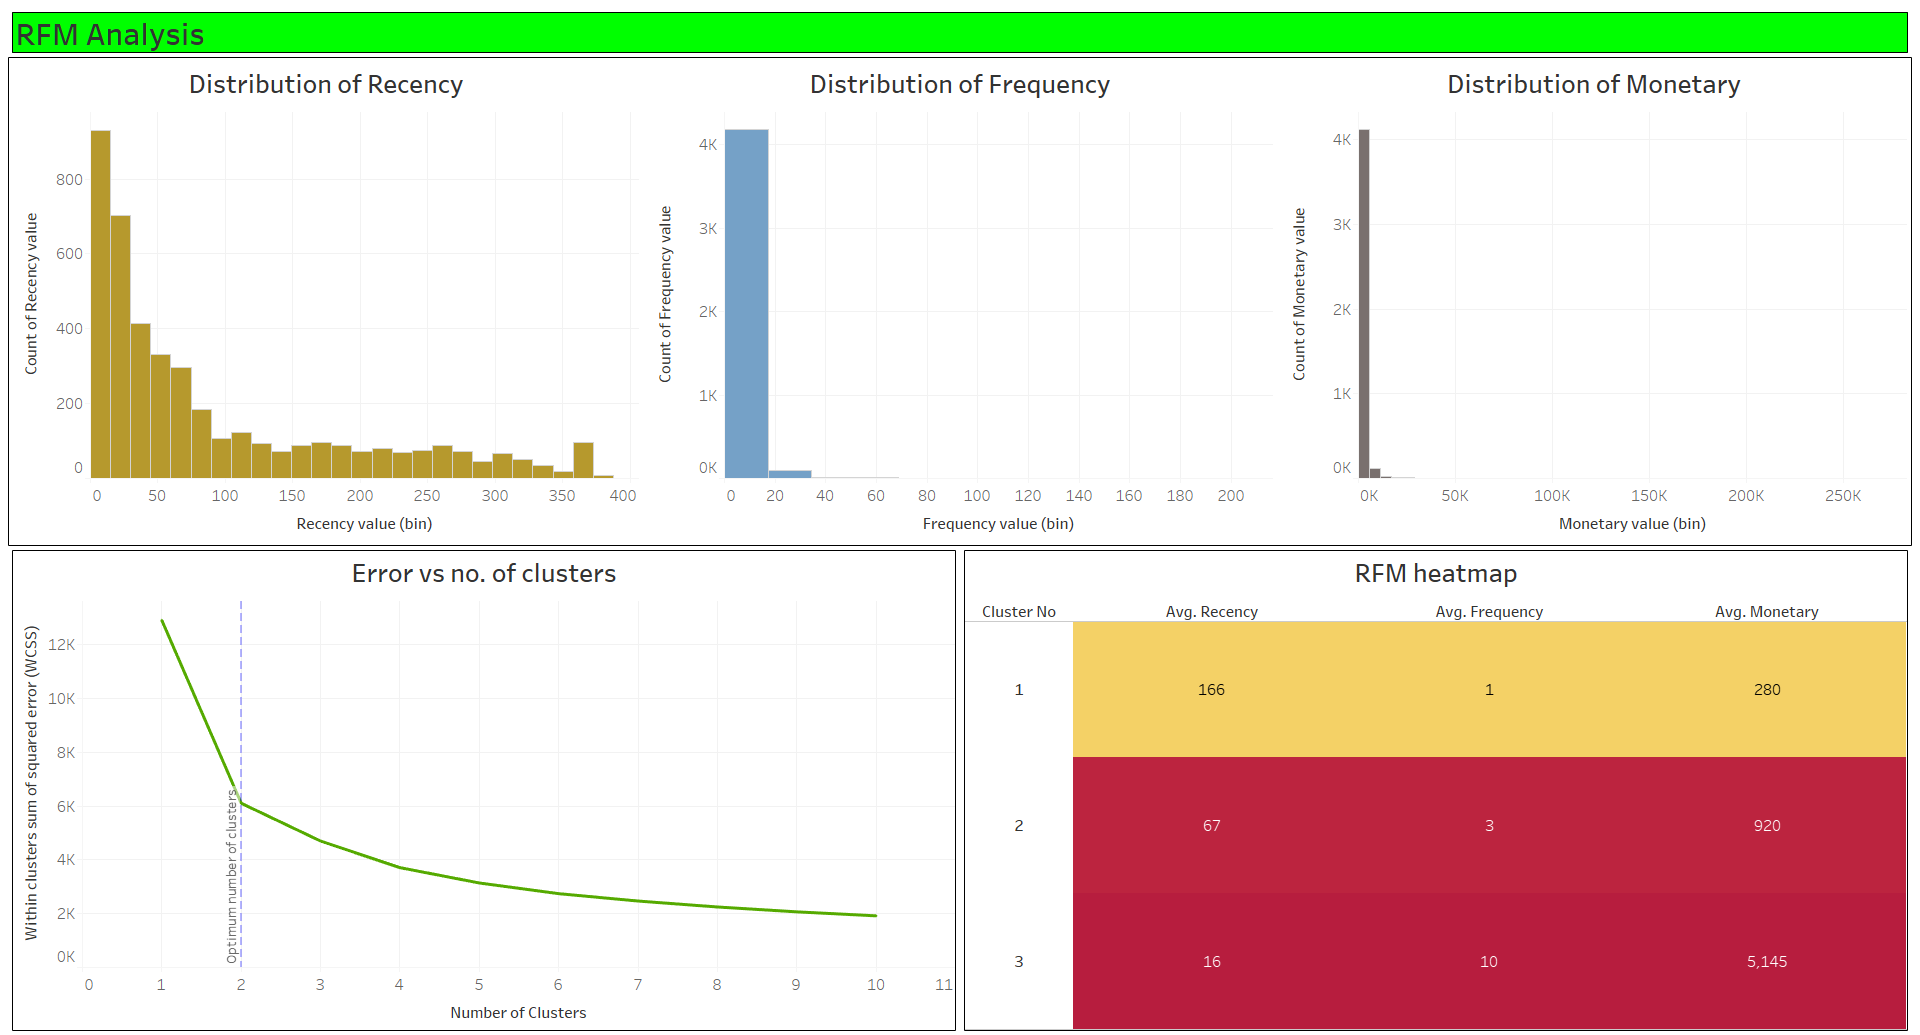

Please open the above dashboard using the following tableau profile link -

https://public.tableau.com/profile/sahaj.harnal#!/vizhome/Project1-RetailPGP/RFManalysisDashboard

### Project completed by: Sahaj Harnal
### Email: sahajharnal@gmail.com